<table align="left" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=8px>
                  <b> AMAZON FAKE REVIEW ANALYSIS </b>
                </font>
            </div>
        </td>
    </tr>
</table>

### Importing the Librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet as wn

from wordcloud import WordCloud
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.metrics import roc_curve, auc,f1_score

### Importing the Data

In [3]:
df = pd.read_excel('reviews_amazon_labels.xlsx')

In [4]:
df = df.drop('DOC_ID',axis=1)

In [5]:
df.head(2)

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...


### Understanding the data

In [6]:
df.shape

(21000, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   LABEL              21000 non-null  object
 1   RATING             21000 non-null  int64 
 2   VERIFIED_PURCHASE  21000 non-null  object
 3   PRODUCT_CATEGORY   21000 non-null  object
 4   PRODUCT_ID         21000 non-null  object
 5   PRODUCT_TITLE      21000 non-null  object
 6   REVIEW_TITLE       20999 non-null  object
 7   REVIEW_TEXT        21000 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.3+ MB


In [8]:
df.describe()

,RATING
count,21000.000000
mean,4.127952
std,1.278333
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [9]:
df.describe(include='O').T

,count,unique,top,freq
LABEL,21000,2,__label1__,10500
VERIFIED_PURCHASE,21000,2,Y,11698
PRODUCT_CATEGORY,21000,30,Camera,700
PRODUCT_ID,21000,18857,B00AWKC0JM,4
PRODUCT_TITLE,21000,18865,Honey Badger Garden Gloves for Digging & Plant...,5
REVIEW_TITLE,20999,18475,Five Stars,83
REVIEW_TEXT,21000,21000,this strings are just for starters because the...,1


### Null Value Treatment

In [10]:
df.isnull().sum()*100/len(df)

LABEL                0.000000
RATING               0.000000
VERIFIED_PURCHASE    0.000000
PRODUCT_CATEGORY     0.000000
PRODUCT_ID           0.000000
PRODUCT_TITLE        0.000000
REVIEW_TITLE         0.004762
REVIEW_TEXT          0.000000
dtype: float64

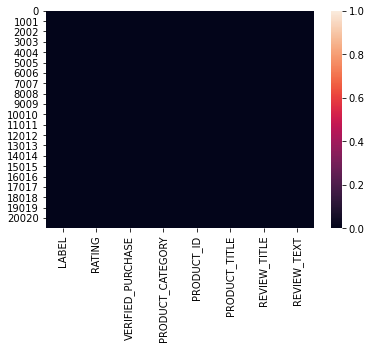

In [11]:
sns.heatmap(df.isnull())
plt.show()

In [11]:
df[df['REVIEW_TITLE'].isnull()]

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
12963,__label2__,5,Y,Outdoors,B0043AK0O4,Coleman Pack-Away Cot with Side Table,NaN,Everything I was hoping for:<br />-Sets up eas...


In [12]:
df = df[pd.notnull(df['REVIEW_TITLE'])]

In [13]:
df.shape

(20999, 8)

### Dummy Encoding

In [14]:
le = LabelEncoder()

In [15]:
df['LABEL'] = le.fit_transform(df['LABEL'])

In [16]:
df['VERIFIED_PURCHASE'] = le.fit_transform(df['VERIFIED_PURCHASE'])

In [17]:
df['RATING'] = le.fit_transform(df['RATING'])

## Visualisation

### Univariate Analysis

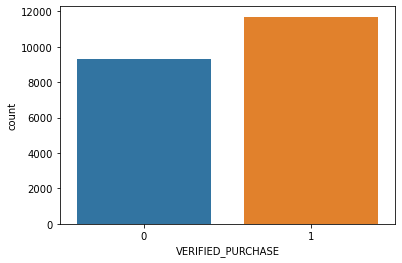

In [18]:
sns.countplot(df['VERIFIED_PURCHASE'])
plt.show()

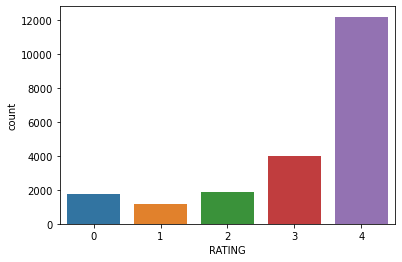

In [19]:
sns.countplot(df['RATING'])
plt.show()

#### Target Variable

In [20]:
df['LABEL'].unique()

array([0, 1])

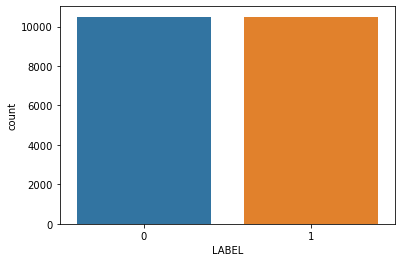

In [21]:
sns.countplot(df['LABEL'])
plt.show()

### Bi-Variate Analysis

#### Finding the relation between other variables with Target Variable

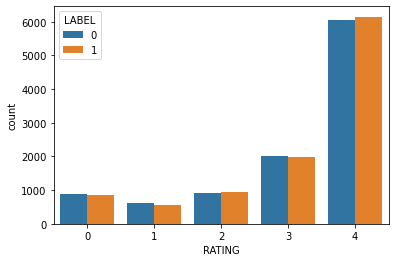

In [22]:
sns.countplot(df['RATING'],hue=df['LABEL'])
plt.show()

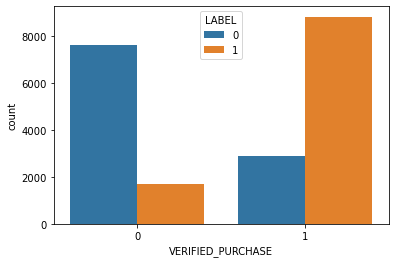

In [23]:
sns.countplot(df['VERIFIED_PURCHASE'],hue=df['LABEL'])
plt.show()

### Multivariate Analysis

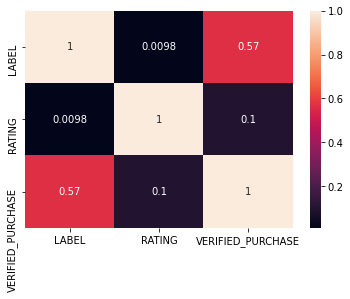

In [24]:
sns.heatmap(df.corr(),annot=True)
plt.show()

## Pre-Processing Steps in NLP for REVIEW_TEXT Column

In [25]:
lemmatizer = WordNetLemmatizer()
#stemmer = PorterStemmer()

In [26]:
def lemmatizing(word):
    lematize = WordNetLemmatizer()
    if(word != lematize.lemmatize(word,pos ='a')):
        return lematize.lemmatize(word,pos ='a')
    elif(word != lematize.lemmatize(word,pos ='v')):
        return lematize.lemmatize(word,pos ='v')
    else:
        return word

In [27]:
# def cleanhtml(raw_html):
#     cleanr = re.compile('<.*?>')
#     cleantext = re.sub(cleanr, '', raw_html)
#     return cleantext

In [28]:
# def lemmatizing_spell_check(word):  
#     if(word != lematize.lemmatize(word,pos ='a')):
#         word =  lematize.lemmatize(word,pos ='a')
#     elif(word != lematize.lemmatize(word,pos ='v')):
#         word  =  lematize.lemmatize(word,pos ='v')
#     #spell checking
# #     if(word != str(spell.correction(word))):
# #         return str(spell.correction(word))
# #     else:
# #         word = TextBlob(word)
# #         word = str(word.correct())
#     return word

In [29]:
def preprocessing(x):
    x = x.lower()   # Lower case conversion
    cleanr = re.compile('<.*?>') # Removing tags
    a = re.sub(cleanr, '', x)
    a = re.findall('[a-z0-9]+', a) # Removing Punctations
    filtered_sentence = [w for w in a if w not in set(stopwords.words('english'))] # Removing Stop words
    #filtered_sentence = list(map(spellChecker,filtered_sentence)) # Spelling checker
    filtered_sentence = list(map(lemmatizing,filtered_sentence)) # Lemmatising the words
    return ' '.join(filtered_sentence)

In [30]:
clean_review_df=pd.DataFrame({'LABEL':df['LABEL'],'REVIEW_TEXT':df['REVIEW_TEXT']})
clean_review_df.head(2)

,LABEL,REVIEW_TEXT
0,0,"When least you think so, this product will sav..."
1,0,Lithium batteries are something new introduced...


In [31]:
# import nltk
# nltk.download('stopwords')

In [32]:
clean_review_df['CLEAN_TEXT'] = df['REVIEW_TEXT'].apply(preprocessing)

In [33]:
clean_review_df.head(2)

,LABEL,REVIEW_TEXT,CLEAN_TEXT
0,0,"When least you think so, this product will sav...",least think product save day keep around case ...
1,0,Lithium batteries are something new introduced...,lithium batteries something new introduce mark...


In [34]:
len(clean_review_df)

20999

## Word Cloud 

### Word Cloud for REVIEW_TEXT column

In [35]:
reviews_list = [review for review in clean_review_df['REVIEW_TEXT']]
review_text_words = ' '.join([i for word in reviews_list for i in word.split()])

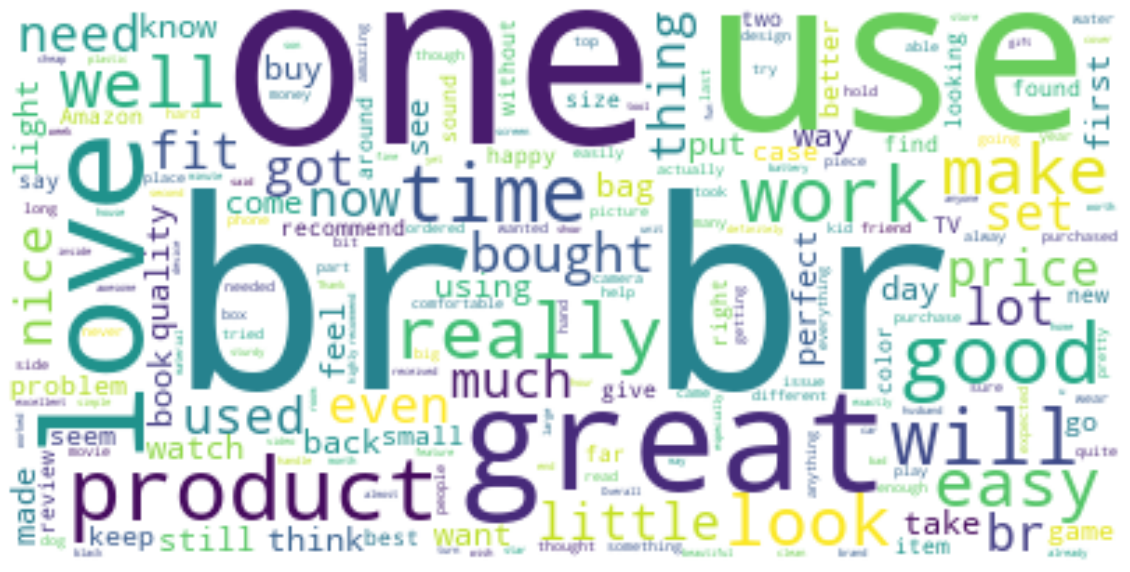

In [36]:
wordcloud_review_text = WordCloud(background_color="white").generate(review_text_words)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_review_text, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud for CLEAN_REVIEW_TEXT Column

In [37]:
clean_reviews_list = [review for review in clean_review_df['CLEAN_TEXT']]
clean_review_text_words = ' '.join([i for word in clean_reviews_list for i in word.split()])

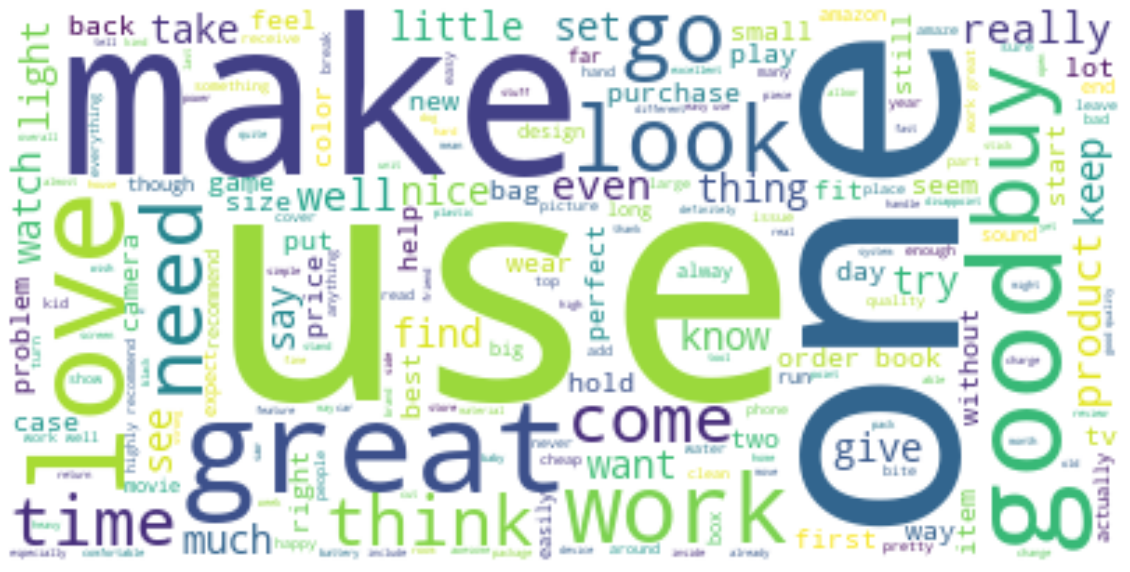

In [38]:
wordcloud_clean_review_text = WordCloud(background_color="white").generate(clean_review_text_words)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_clean_review_text, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
df_final=pd.DataFrame({'LABEL':clean_review_df['LABEL'],'CLEAN_TEXT':clean_review_df['CLEAN_TEXT']})
df_final.head(2)

,LABEL,CLEAN_TEXT
0,0,least think product save day keep around case ...
1,0,lithium batteries something new introduce mark...


### Visualisation of CLEAN_TEXT Column 

### Number of words in each Review

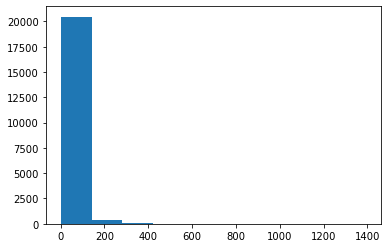

In [40]:
clean_review_df['LENGTH_OF_REVIEW']=clean_review_df['CLEAN_TEXT'].apply(lambda x: len(str(x).split(" ")))
plt.hist(clean_review_df['LENGTH_OF_REVIEW'])
plt.show()

### Number of Characters in each Review

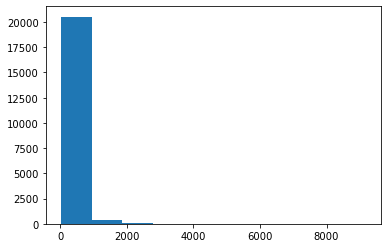

In [41]:
clean_review_df['LENGTH_OF_REVIEW_CHAR']=clean_review_df['CLEAN_TEXT'].apply(lambda x: len(str(x)))
plt.hist(clean_review_df['LENGTH_OF_REVIEW_CHAR'])
plt.show()

### Average Number of Words length in each Review

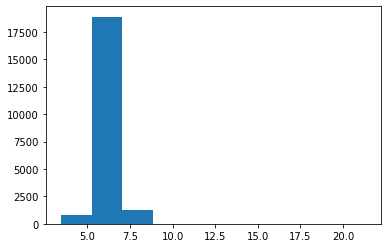

In [42]:
clean_review_df['average_word_len']=clean_review_df['CLEAN_TEXT'].apply(lambda x: len(x)/len(str(x).split(" ")))
plt.hist(clean_review_df['average_word_len'])
plt.show()

# Approach I

### Count Vectorizer

In [45]:
cv = CountVectorizer(max_features=7000,ngram_range=(1,2))

In [46]:
y_cv = df_final['LABEL']

In [47]:
x_cv = cv.fit_transform(df_final['CLEAN_TEXT']).toarray()

In [48]:
x_cv.shape

(20999, 7000)

### Train Test Split for CV

In [49]:
X_cv_train,X_cv_test,y_cv_train,y_cv_test=train_test_split(x_cv,y_cv,test_size=0.2,random_state=42)

In [50]:
print(X_cv_train.shape)
print(X_cv_test.shape)
print(y_cv_train.shape)
print(y_cv_test.shape)

(16799, 7000)
(4200, 7000)
(16799,)
(4200,)


In [51]:
# Printing the identified Unique words along with their indices
print("Vocabulary: ", cv.vocabulary_)

Vocabulary:  {'least': 3269, 'think': 6075, 'product': 4676, 'save': 5228, 'day': 1406, 'keep': 3136, 'around': 386, 'case': 912, 'need': 3983, 'something': 5618, 'think product': 6092, 'need something': 4002, 'batteries': 531, 'new': 4038, 'introduce': 3070, 'market': 3720, 'average': 440, 'develop': 1517, 'cost': 1268, 'relatively': 5043, 'high': 2852, 'quality': 4798, 'provide': 4745, 'us': 6400, 'best': 580, 'low': 3596, 'many': 3702, 'build': 772, 'technical': 6011, 'act': 151, 'like': 3332, 'sensor': 5359, 'particular': 4353, 'battery': 533, 'phone': 4435, 'charge': 959, 'work': 6831, 'every': 1882, 'voltage': 6568, 'never': 4022, 'risk': 5155, 'something new': 5624, 'low cost': 3597, 'work every': 6837, 'purchase': 4763, 'swing': 5937, 'baby': 451, 'months': 3874, 'pretty': 4598, 'much': 3908, 'grow': 2725, 'loud': 3542, 'well': 6709, 'beautiful': 551, 'though': 6101, 'love': 3543, 'color': 1087, 'lot': 3526, 'settings': 5389, 'worth': 6878, 'money': 3860, 'pretty much': 4604, '

# Approch II

## TF-IDF

In [66]:
tfidf = TfidfVectorizer(max_features=7000, ngram_range=(1,2))

In [67]:
y_tfidf = df_final[['LABEL']]

In [68]:
x_tfidf = tfidf.fit_transform(df_final['CLEAN_TEXT']).toarray()

In [69]:
x_tfidf.shape

(20999, 7000)

## Train Test Split for TF-IDF

In [70]:
X_tfidf_train,X_tfidf_test,y_tfidf_train,y_tfidf_test=train_test_split(x_tfidf,y_tfidf,test_size=0.2,random_state=42)

In [71]:
print(X_tfidf_train.shape)
print(X_tfidf_test.shape)
print(y_tfidf_train.shape)
print(y_tfidf_test.shape)

(16799, 7000)
(4200, 7000)
(16799, 1)
(4200, 1)


In [72]:
# Printing the identified Unique words along with their indices
print("Vocabulary: ", tfidf.vocabulary_)

Vocabulary:  {'least': 3269, 'think': 6075, 'product': 4676, 'save': 5228, 'day': 1406, 'keep': 3136, 'around': 386, 'case': 912, 'need': 3983, 'something': 5618, 'think product': 6092, 'need something': 4002, 'batteries': 531, 'new': 4038, 'introduce': 3070, 'market': 3720, 'average': 440, 'develop': 1517, 'cost': 1268, 'relatively': 5043, 'high': 2852, 'quality': 4798, 'provide': 4745, 'us': 6400, 'best': 580, 'low': 3596, 'many': 3702, 'build': 772, 'technical': 6011, 'act': 151, 'like': 3332, 'sensor': 5359, 'particular': 4353, 'battery': 533, 'phone': 4435, 'charge': 959, 'work': 6831, 'every': 1882, 'voltage': 6568, 'never': 4022, 'risk': 5155, 'something new': 5624, 'low cost': 3597, 'work every': 6837, 'purchase': 4763, 'swing': 5937, 'baby': 451, 'months': 3874, 'pretty': 4598, 'much': 3908, 'grow': 2725, 'loud': 3542, 'well': 6709, 'beautiful': 551, 'though': 6101, 'love': 3543, 'color': 1087, 'lot': 3526, 'settings': 5389, 'worth': 6878, 'money': 3860, 'pretty much': 4604, '

# Model 1

## Logistic Regression for CV

In [52]:
lr_cv = LogisticRegression()

In [53]:
lr_cv.fit(X_cv_train,y_cv_train)

LogisticRegression()

In [54]:
lr_cv.coef_

array([[ 0.85473811, -0.66526029,  0.45326222, ...,  0.5814465 ,
        -0.20377808, -0.17664284]])

In [55]:
lr_cv.intercept_

array([-0.09769784])

In [58]:
print("Training Accuracy")
lr_cv.score(X_cv_train,y_cv_train)

Training Accuracy


0.8439788082623966

In [59]:
print("Testing Accuracy")
lr_cv.score(X_cv_test,y_cv_test)

Testing Accuracy


0.6221428571428571

### Metrics for Logistic Regression - CV

#### Confusion Matrix and Classification Report for Logistic Regression

[[7108 1259]
 [1362 7070]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      8367
           1       0.85      0.84      0.84      8432

    accuracy                           0.84     16799
   macro avg       0.84      0.84      0.84     16799
weighted avg       0.84      0.84      0.84     16799



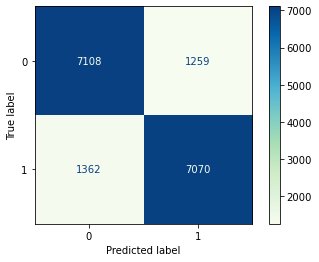

In [57]:
predicted_lr_cv_train = lr_cv.predict(X_cv_train)
print(confusion_matrix(y_cv_train,predicted_lr_cv_train))
print("-"*50)
print(plot_confusion_matrix(lr_cv,X_cv_train,y_cv_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_train,predicted_lr_cv_train))

[[1370  763]
 [ 824 1243]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      2133
           1       0.62      0.60      0.61      2067

    accuracy                           0.62      4200
   macro avg       0.62      0.62      0.62      4200
weighted avg       0.62      0.62      0.62      4200



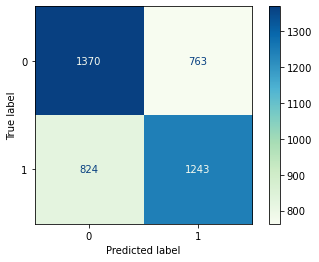

In [60]:
predicted_lr_cv_test = lr_cv.predict(X_cv_test)
print(confusion_matrix(y_cv_test,predicted_lr_cv_test))
print("-"*50)
print(plot_confusion_matrix(lr_cv,X_cv_test,y_cv_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_test,predicted_lr_cv_test))

#### ROC curve and Area under the curve for Logistic Regression

In [61]:
probas_lr_cv_train = lr_cv.predict_proba(X_cv_train)

In [62]:
probas_lr_cv_test = lr_cv.predict_proba(X_cv_test)

In [63]:
# Compute ROC curve and area the curve for logistic
fpr_lr_cv_train, tpr_lr_cv_train, thresholds_lr_cv_train = roc_curve(y_cv_train, probas_lr_cv_train[:, 1])
roc_auc_lr_cv_train = auc(fpr_lr_cv_train, tpr_lr_cv_train)
print("Area under the ROC curve : %f" % roc_auc_lr_cv_train)

Area under the ROC curve : 0.927197


In [64]:
# Compute ROC curve and area the curve for logistic
fpr_lr_cv_test, tpr_lr_cv_test, thresholds_lr_cv_test = roc_curve(y_cv_test, probas_lr_cv_test[:, 1])
roc_auc_lr_cv_test = auc(fpr_lr_cv_test, tpr_lr_cv_test)
print("Area under the ROC curve : %f" % roc_auc_lr_cv_test)

Area under the ROC curve : 0.674529


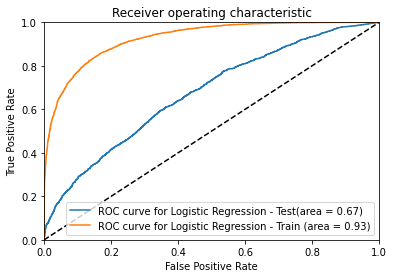

In [65]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_lr_cv_test, tpr_lr_cv_test, label='ROC curve for Logistic Regression - Test(area = %0.2f)' % roc_auc_lr_cv_test)
pl.plot(fpr_lr_cv_train, tpr_lr_cv_train, label='ROC curve for Logistic Regression - Train (area = %0.2f)' 
        % roc_auc_lr_cv_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

## Logistic Regression for TF-IDF

In [73]:
lr_tfidf = LogisticRegression()

In [74]:
lr_tfidf.fit(X_tfidf_train,y_tfidf_train)

LogisticRegression()

In [75]:
lr_tfidf.coef_

array([[ 1.12284857, -0.22712232,  1.59063459, ...,  0.41680267,
        -0.22547583,  0.17018087]])

In [76]:
lr_tfidf.intercept_

array([-0.14356497])

In [77]:
print("Training Accuracy")
lr_tfidf.score(X_tfidf_train,y_tfidf_train)

Training Accuracy


0.7682004881242931

In [78]:
print("Testing Accuracy")
lr_tfidf.score(X_tfidf_test,y_tfidf_test)

Testing Accuracy


0.6514285714285715

### Metrics for Logistic Regression - TF-IDF 

#### Confusion Matrix and Classification Report for Logistic Regression

In [79]:
predicted_lr_tfidf_test = lr_tfidf.predict(X_tfidf_test)
predicted_lr_tfidf_train = lr_tfidf.predict(X_tfidf_train)

[[6348 2019]
 [1875 6557]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      8367
           1       0.76      0.78      0.77      8432

    accuracy                           0.77     16799
   macro avg       0.77      0.77      0.77     16799
weighted avg       0.77      0.77      0.77     16799



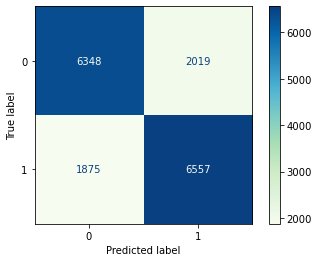

In [80]:
print(confusion_matrix(y_tfidf_train,predicted_lr_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(lr_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_lr_tfidf_train))

[[1407  726]
 [ 738 1329]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      2133
           1       0.65      0.64      0.64      2067

    accuracy                           0.65      4200
   macro avg       0.65      0.65      0.65      4200
weighted avg       0.65      0.65      0.65      4200



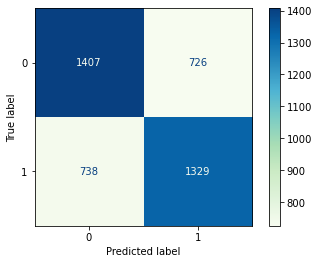

In [81]:
print(confusion_matrix(y_tfidf_test,predicted_lr_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(lr_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_lr_tfidf_test))

#### ROC curve and Area under the curve for Logistic Regression

In [82]:
probas_lr_tfidf_train = lr_tfidf.predict_proba(X_tfidf_train)

In [83]:
probas_lr_tfidf_test = lr_tfidf.predict_proba(X_tfidf_test)

In [84]:
# Compute ROC curve and area the curve for logistic
fpr_lr_tfidf_train, tpr_lr_tfidf_train, thresholds_lr_tfidf_train = roc_curve(y_tfidf_train, probas_lr_tfidf_train[:, 1])
roc_auc_lr_tfidf_train= auc(fpr_lr_tfidf_train, tpr_lr_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_lr_tfidf_train)

Area under the ROC curve : 0.848955


In [85]:
# Compute ROC curve and area the curve for logistic
fpr_lr_tfidf_test, tpr_lr_tfidf_test, thresholds_lr_tfidf_test = roc_curve(y_tfidf_test, probas_lr_tfidf_test[:, 1])
roc_auc_lr_tfidf_test = auc(fpr_lr_tfidf_test, tpr_lr_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_lr_tfidf_test)

Area under the ROC curve : 0.711467


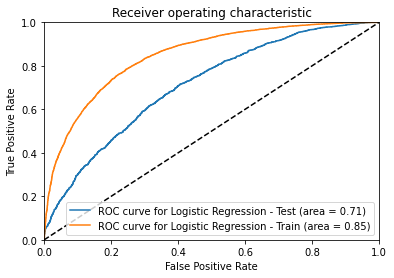

In [86]:
# Plot the ROC
pl.clf()
pl.plot(fpr_lr_tfidf_test, tpr_lr_tfidf_test, label='ROC curve for Logistic Regression - Test (area = %0.2f)' 
        % roc_auc_lr_tfidf_test)
pl.plot(fpr_lr_tfidf_train, tpr_lr_tfidf_train, label='ROC curve for Logistic Regression - Train (area = %0.2f)'
        % roc_auc_lr_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model 2

## Decision Tree  for CV

In [92]:
dt_cv= DecisionTreeClassifier()
dt_cv.fit(X_cv_train,y_cv_train)

DecisionTreeClassifier()

In [93]:
print("Training Accuracy")
dt_cv.score(X_cv_train,y_cv_train)

Training Accuracy


1.0

In [94]:
print("Testing Accuracy")
dt_cv.score(X_cv_test,y_cv_test)

Testing Accuracy


0.5547619047619048

### Metrics for Decision Tree  - CV

#### Confusion Matrix and Classification Report for Decision Tree 

[[8367    0]
 [   0 8432]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8367
           1       1.00      1.00      1.00      8432

    accuracy                           1.00     16799
   macro avg       1.00      1.00      1.00     16799
weighted avg       1.00      1.00      1.00     16799



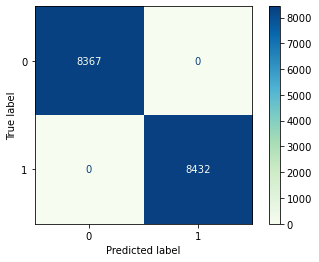

In [95]:
predicted_cv_train = dt_cv.predict(X_cv_train)
print(confusion_matrix(y_cv_train,predicted_cv_train))
print(plot_confusion_matrix(dt_cv,X_cv_train,y_cv_train, cmap = "GnBu"))
print(classification_report(y_cv_train,predicted_cv_train))

[[1214  919]
 [ 951 1116]]
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      2133
           1       0.55      0.54      0.54      2067

    accuracy                           0.55      4200
   macro avg       0.55      0.55      0.55      4200
weighted avg       0.55      0.55      0.55      4200



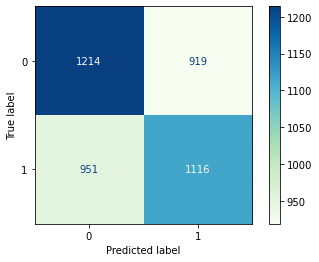

In [96]:
predicted_cv_test = dt_cv.predict(X_cv_test)
print(confusion_matrix(y_cv_test,predicted_cv_test))
print(plot_confusion_matrix(dt_cv,X_cv_test,y_cv_test, cmap = "GnBu"))
print(classification_report(y_cv_test,predicted_cv_test))

In [97]:
probas_cv_train = dt_cv.predict_proba(X_cv_train)
probas_cv_test = dt_cv.predict_proba(X_cv_test)

In [98]:
fpr_cv_train, tpr_cv_train, thresholds_cv_train = roc_curve(y_cv_train, probas_cv_train[:, 1])
roc_auc_cv_train = auc(fpr_cv_train, tpr_cv_train)
print("Area under the ROC curve : %f" % roc_auc_cv_train)

Area under the ROC curve : 1.000000


In [99]:
fpr_cv_test, tpr_cv_test, thresholds_cv_test = roc_curve(y_cv_test, probas_cv_test[:, 1])
roc_auc_cv_test = auc(fpr_cv_test, tpr_cv_test)
print("Area under the ROC curve : %f" % roc_auc_cv_test)

Area under the ROC curve : 0.554532


#### ROC curve and Area under the curve for Decision Tree 

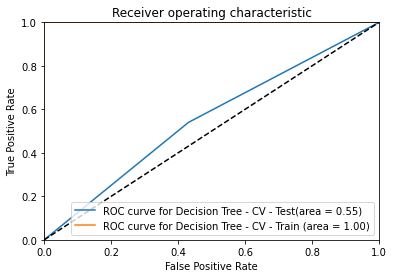

In [100]:
pl.clf()
pl.plot(fpr_cv_test, tpr_cv_test, label='ROC curve for Decision Tree - CV - Test(area = %0.2f)' % roc_auc_cv_test)
pl.plot(fpr_cv_train, tpr_cv_train, label='ROC curve for Decision Tree - CV - Train (area = %0.2f)' % roc_auc_cv_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

## Decision Tree  for TFIDF

In [101]:
DT_tfidf= DecisionTreeClassifier()
DT_tfidf.fit(X_tfidf_train,y_tfidf_train)

DecisionTreeClassifier()

In [102]:
print("Training Accuracy")
DT_tfidf.score(X_tfidf_train,y_tfidf_train)

Training Accuracy


1.0

In [103]:
print("Testing Accuracy")
DT_tfidf.score(X_tfidf_test,y_tfidf_test)

Testing Accuracy


0.5692857142857143

### Metrics for Decision Tree  - TFIDF

#### Confusion Matrix and Classification Report for Decision Tree 

In [104]:
predicted_DT_tfidf_test = DT_tfidf.predict(X_tfidf_test)
predicted_DT_tfidf_train = DT_tfidf.predict(X_tfidf_train)

[[8367    0]
 [   0 8432]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8367
           1       1.00      1.00      1.00      8432

    accuracy                           1.00     16799
   macro avg       1.00      1.00      1.00     16799
weighted avg       1.00      1.00      1.00     16799



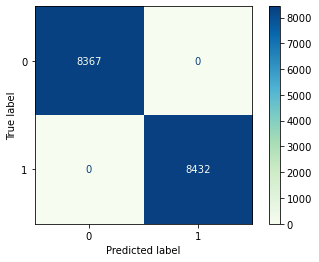

In [105]:
print(confusion_matrix(y_tfidf_train,predicted_DT_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(DT_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_DT_tfidf_train))

[[1204  929]
 [ 880 1187]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2133
           1       0.56      0.57      0.57      2067

    accuracy                           0.57      4200
   macro avg       0.57      0.57      0.57      4200
weighted avg       0.57      0.57      0.57      4200



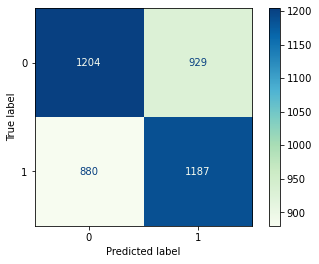

In [106]:
print(confusion_matrix(y_tfidf_test,predicted_DT_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(DT_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_DT_tfidf_test))

#### ROC curve and Area under the curve for Decision Tree

In [107]:
probas_DT_tfidf_train = DT_tfidf.predict_proba(X_tfidf_train)

In [108]:
probas_DT_tfidf_test = DT_tfidf.predict_proba(X_tfidf_test)

In [109]:
fpr_DT_tfidf_train, tpr_DT_tfidf_train, thresholds_DT_tfidf_train = roc_curve(y_tfidf_train, probas_DT_tfidf_train[:, 1])
roc_auc_DT_tfidf_train= auc(fpr_DT_tfidf_train, tpr_DT_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_DT_tfidf_train)

Area under the ROC curve : 1.000000


In [110]:
fpr_DT_tfidf_test, tpr_DT_tfidf_test, thresholds_DT_tfidf_test = roc_curve(y_tfidf_test, probas_DT_tfidf_test[:, 1])
roc_auc_DT_tfidf_test = auc(fpr_DT_tfidf_test, tpr_DT_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_DT_tfidf_test)

Area under the ROC curve : 0.569363


#### ROC curve and Area under the curve for Decision Tree 

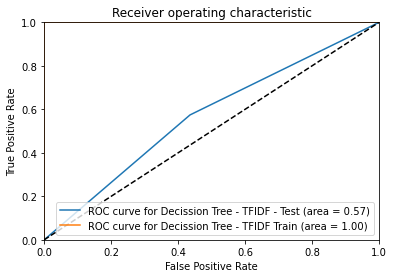

In [111]:
# Plot the ROC
pl.clf()
pl.plot(fpr_DT_tfidf_test, tpr_DT_tfidf_test, label='ROC curve for Decission Tree - TFIDF - Test (area = %0.2f)' 
        % roc_auc_DT_tfidf_test)
pl.plot(fpr_DT_tfidf_train, tpr_DT_tfidf_train, label='ROC curve for Decission Tree - TFIDF Train (area = %0.2f)'
        % roc_auc_DT_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model 3

## Random Forest   for CV

In [112]:
rf_cv = RandomForestClassifier(random_state=10)

In [113]:
rf_cv.fit(X_cv_train,y_cv_train)

RandomForestClassifier(random_state=10)

In [114]:
print("Training Accuracy")
rf_cv.score(X_cv_train,y_cv_train)

Training Accuracy


1.0

In [115]:
print("Testing Accuracy")
rf_cv.score(X_cv_test,y_cv_test)

Testing Accuracy


0.6469047619047619

### Metrics for Random Forest - CV

#### Confusion Matrix and Classification Report for Random Forest

In [116]:
predicted_rf_cv_train = rf_cv.predict(X_cv_train)
predicted_rf_cv_test = rf_cv.predict(X_cv_test)

[[8367    0]
 [   0 8432]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8367
           1       1.00      1.00      1.00      8432

    accuracy                           1.00     16799
   macro avg       1.00      1.00      1.00     16799
weighted avg       1.00      1.00      1.00     16799



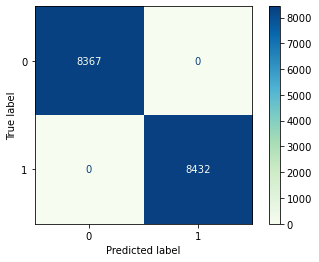

In [117]:
print(confusion_matrix(y_cv_train,predicted_rf_cv_train))
print("-"*50)
print(plot_confusion_matrix(rf_cv,X_cv_train,y_cv_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_train,predicted_rf_cv_train))

[[1350  783]
 [ 700 1367]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.63      0.65      2133
           1       0.64      0.66      0.65      2067

    accuracy                           0.65      4200
   macro avg       0.65      0.65      0.65      4200
weighted avg       0.65      0.65      0.65      4200



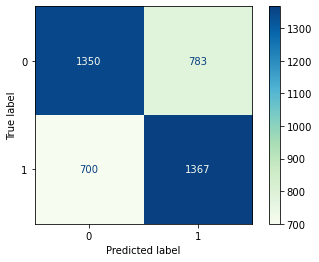

In [118]:
print(confusion_matrix(y_cv_test,predicted_rf_cv_test))
print("-"*50)
print(plot_confusion_matrix(rf_cv,X_cv_test,y_cv_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_test,predicted_rf_cv_test))

#### ROC curve and Area under the curve for Random Forest

In [119]:
fpr_rf_cv_train, tpr_rf_cv_train, thresholds_rf_cv_train = roc_curve(y_cv_train, predicted_rf_cv_train)
roc_auc_rf_cv_train = auc(fpr_rf_cv_train, tpr_rf_cv_train)
print("Area under the ROC curve : %f" % roc_auc_rf_cv_train)

Area under the ROC curve : 1.000000


In [120]:
fpr_rf_cv_test, tpr_rf_cv_test, thresholds_rf_cv_test = roc_curve(y_cv_test, predicted_rf_cv_test)
roc_auc_rf_cv_test = auc(fpr_rf_cv_test, tpr_rf_cv_test)
print("Area under the ROC curve : %f" % roc_auc_rf_cv_test)

Area under the ROC curve : 0.647128


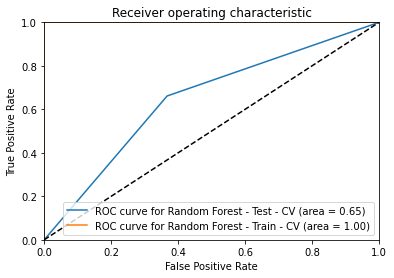

In [121]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_rf_cv_test, tpr_rf_cv_test, label='ROC curve for Random Forest - Test - CV (area = %0.2f)' % roc_auc_rf_cv_test)
pl.plot(fpr_rf_cv_train, tpr_rf_cv_train, label='ROC curve for Random Forest - Train - CV (area = %0.2f)' % roc_auc_rf_cv_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

## Random Forest  for TFIDF

In [124]:
rf_tfidf = RandomForestClassifier(random_state=10)

In [125]:
rf_tfidf.fit(X_tfidf_train,y_tfidf_train)

RandomForestClassifier(random_state=10)

In [126]:
print("Training Accuracy")
rf_tfidf.score(X_tfidf_train,y_tfidf_train)

Training Accuracy


1.0

In [127]:
print("Testing Accuracy")
rf_tfidf.score(X_tfidf_test,y_tfidf_test)

Testing Accuracy


0.6545238095238095

### Metrics for Random Forest - TFIDF

#### Confusion Matrix and Classification Report for Random Forest

In [128]:
predicted_rf_tfidf_train = rf_tfidf.predict(X_tfidf_train)
predicted_rf_tfidf_test = rf_tfidf.predict(X_tfidf_test)

[[8367    0]
 [   0 8432]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8367
           1       1.00      1.00      1.00      8432

    accuracy                           1.00     16799
   macro avg       1.00      1.00      1.00     16799
weighted avg       1.00      1.00      1.00     16799



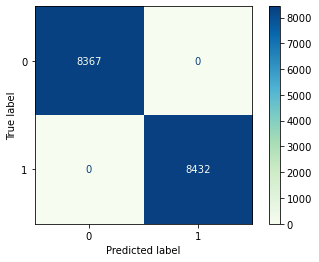

In [129]:
print(confusion_matrix(y_tfidf_train,predicted_rf_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(rf_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_rf_tfidf_train))

[[1438  695]
 [ 756 1311]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.67      0.66      2133
           1       0.65      0.63      0.64      2067

    accuracy                           0.65      4200
   macro avg       0.65      0.65      0.65      4200
weighted avg       0.65      0.65      0.65      4200



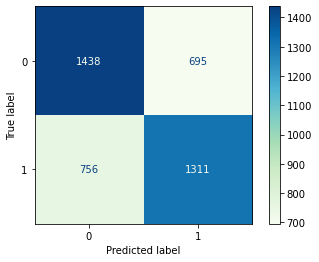

In [130]:
print(confusion_matrix(y_tfidf_test,predicted_rf_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(rf_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_rf_tfidf_test))

#### ROC curve and Area under the curve for Random Forest

In [131]:
fpr_rf_tfidf_train, tpr_rf_tfidf_train, thresholds_rf_tfidf_train = roc_curve(y_tfidf_train, predicted_rf_tfidf_train)
roc_auc_rf_tfidf_train = auc(fpr_rf_tfidf_train, tpr_rf_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_rf_tfidf_train)

Area under the ROC curve : 1.000000


In [132]:
fpr_rf_tfidf_test, tpr_rf_tfidf_test, thresholds_rf_tfidf_test = roc_curve(y_tfidf_test, predicted_rf_tfidf_test)
roc_auc_rf_tfidf_test = auc(fpr_rf_tfidf_test, tpr_rf_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_rf_tfidf_test)

Area under the ROC curve : 0.654210


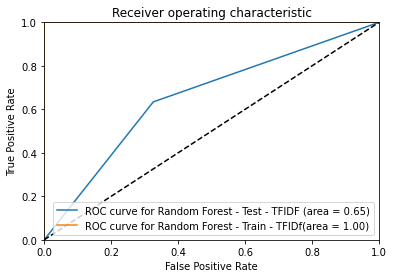

In [133]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_rf_tfidf_test, tpr_rf_tfidf_test, label='ROC curve for Random Forest - Test - TFIDF (area = %0.2f)' 
        % roc_auc_rf_tfidf_test)
pl.plot(fpr_rf_tfidf_train, tpr_rf_tfidf_train, label='ROC curve for Random Forest - Train - TFIDf(area = %0.2f)' 
        % roc_auc_rf_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model  4

## KNN  for CV

In [77]:
knn_cv=KNeighborsClassifier(n_neighbors=5,n_jobs=-1)

In [78]:
knn_cv.fit(X_cv_train, y_cv_train)

KNeighborsClassifier(n_jobs=-1)

In [79]:
print("Training Accuracy")
train_accuracy_knn = knn_cv.score(X_cv_train,y_cv_train)
print(train_accuracy_knn)

Training Accuracy
0.6327162331091136


In [80]:
print("Testing Accuracy")
test_accuracy_knn = knn_cv.score(X_cv_test,y_cv_test)
print(test_accuracy_knn)

Testing Accuracy
0.5159523809523809


### Metrics for CV

#### Confusion Matrix and Classification Report for KNN 

In [81]:
predicted_cv_knn_train = knn_cv.predict(X_cv_train)

Confusion Matrix
------------------------------------------------------------
[[3208 5159]
 [1011 7421]]
------------------------------------------------------------
Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.38      0.51      8367
           1       0.59      0.88      0.71      8432

    accuracy                           0.63     16799
   macro avg       0.68      0.63      0.61     16799
weighted avg       0.67      0.63      0.61     16799



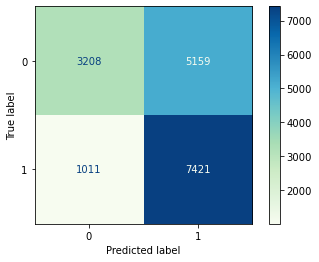

In [82]:
print("Confusion Matrix")
print("-"*60)
print(confusion_matrix(y_cv_train,predicted_cv_knn_train))
print("-"*60)
print(plot_confusion_matrix(knn_cv,X_cv_train,y_cv_train, cmap = "GnBu"))
print("Classification Report")
print("-"*60)
print(classification_report(y_cv_train,predicted_cv_knn_train))

In [83]:
predicted_cv_knn_test = knn_cv.predict(X_cv_test)

Confusion Matrix
------------------------------------------------------------
[[ 505 1628]
 [ 405 1662]]
------------------------------------------------------------
Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.24      0.33      2133
           1       0.51      0.80      0.62      2067

    accuracy                           0.52      4200
   macro avg       0.53      0.52      0.48      4200
weighted avg       0.53      0.52      0.47      4200



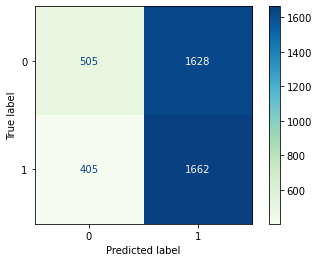

In [84]:
print("Confusion Matrix")
print("-"*60)
print(confusion_matrix(y_cv_test,predicted_cv_knn_test))
print("-"*60)
print(plot_confusion_matrix(knn_cv,X_cv_test,y_cv_test, cmap = "GnBu"))
print("Classification Report")
print("-"*60)
print(classification_report(y_cv_test,predicted_cv_knn_test))

In [86]:
from sklearn.model_selection import cross_val_score
scoresrf = cross_val_score(knn_cv, X_cv_train, y_cv_train, cv=10, scoring='accuracy')
print(np.mean(scoresrf))

0.5190781786210612


#### ROC curve and Area under the curve for KNN

In [87]:
probas_cv_knn_train = knn_cv.predict_proba(X_cv_train)

In [88]:
probas_cv_knn_test = knn_cv.predict_proba(X_cv_test)

In [89]:
fpr_cv_knn_train, tpr_cv_knn_train, thresholds_cv_knn_train = roc_curve(y_cv_train, probas_cv_knn_train[:, 1])
roc_auc_cv_knn_train = auc(fpr_cv_knn_train, tpr_cv_knn_train)
print("Area under the ROC curve for cv train set  : %f" % roc_auc_cv_knn_train)

Area under the ROC curve for cv train set  : 0.770686


In [90]:
fpr_cv_knn_test, tpr_cv_knn_test, thresholds_cv_knn_test = roc_curve(y_cv_test, probas_cv_knn_test[:, 1])
roc_auc_cv_knn_test= auc(fpr_cv_knn_test, tpr_cv_knn_test)
print("Area under the ROC curve for cv test set  : %f" % roc_auc_cv_knn_test)

Area under the ROC curve for cv test set  : 0.537881


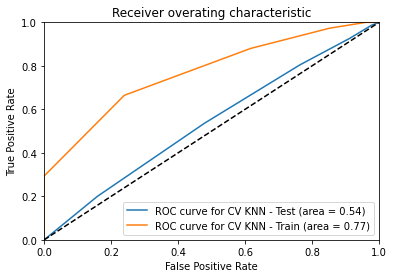

In [91]:
pl.clf()
pl.plot(fpr_cv_knn_test, tpr_cv_knn_test, label='ROC curve for CV KNN - Test (area = %0.2f)' % roc_auc_cv_knn_test)
pl.plot(fpr_cv_knn_train, tpr_cv_knn_train, label='ROC curve for CV KNN - Train (area = %0.2f)'
        % roc_auc_cv_knn_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

## KNN   for TFIDF

In [129]:
knn_tfidf = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)

In [130]:
knn_tfidf.fit(X_tfidf_train, y_tfidf_train)

KNeighborsClassifier(n_jobs=-1)

In [131]:
print("Training Accuracy")
train_tfidf_knn_acc_score=knn_tfidf.score(X_tfidf_train,y_tfidf_train)
print(train_tfidf_knn_acc_score)

Training Accuracy
0.6851003035894994


In [132]:
print("Testing Accuracy")
test_tfidf_knn_acc_score=knn_tfidf.score(X_tfidf_test,y_tfidf_test)
print(test_tfidf_knn_acc_score)

Testing Accuracy
0.5592857142857143


### Metrics for KNN  - TFIDF

#### Confusion Matrix and Classification Report for KNN

In [133]:
predicted_tfidf_knn_train = knn_tfidf.predict(X_tfidf_train)

Confusion Matrix
------------------------------------------------------------
[[3103 5264]
 [  26 8406]]
------------------------------------------------------------
Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.37      0.54      8367
           1       0.61      1.00      0.76      8432

    accuracy                           0.69     16799
   macro avg       0.80      0.68      0.65     16799
weighted avg       0.80      0.69      0.65     16799



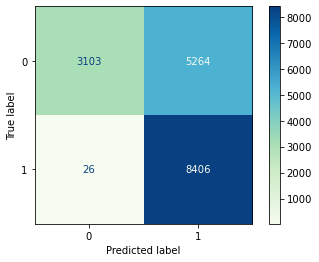

In [134]:
print("Confusion Matrix")
print("-"*60)
print(confusion_matrix(y_tfidf_train,predicted_tfidf_knn_train))
print("-"*60)
print(plot_confusion_matrix(knn_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("Classification Report")
print("-"*60)
print(classification_report(y_tfidf_train,predicted_tfidf_knn_train))

In [135]:
predicted_tfidf_knn_test = knn_tfidf.predict(X_tfidf_test)

Confusion Matrix
------------------------------------------------------------
[[ 525 1608]
 [ 243 1824]]
------------------------------------------------------------
Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.25      0.36      2133
           1       0.53      0.88      0.66      2067

    accuracy                           0.56      4200
   macro avg       0.61      0.56      0.51      4200
weighted avg       0.61      0.56      0.51      4200



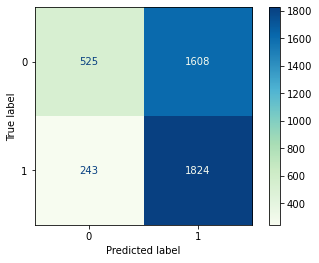

In [136]:
print("Confusion Matrix")
print("-"*60)
print(confusion_matrix(y_tfidf_test,predicted_tfidf_knn_test))
print("-"*60)
print(plot_confusion_matrix(knn_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("Classification Report")
print("-"*60)
print(classification_report(y_tfidf_test,predicted_tfidf_knn_test))

#### ROC curve and Area under the curve for  KNN

In [137]:
probas_tfidf_knn_train = knn_tfidf.predict_proba(X_tfidf_train)

In [138]:
probas_tfidf_knn_test = knn_tfidf.predict_proba(X_tfidf_test)

In [139]:
fpr_tfidf_knn_train, tpr_tfidf_knn_train, thresholds_tfidf_knn_train = roc_curve(y_tfidf_train, probas_tfidf_knn_train[:, 1])
roc_auc_tfidf_knn_train = auc(fpr_tfidf_knn_train, tpr_tfidf_knn_train)
print("Area under the ROC curve for tfidf knn train set : %f" % roc_auc_tfidf_knn_train)

Area under the ROC curve for tfidf knn train set : 0.859322


In [140]:
fpr_tfidf_knn_test, tpr_tfidf_knn_test, thresholds_tfidf_knn_test = roc_curve(y_tfidf_test, probas_tfidf_knn_test[:, 1])
roc_auc_tfidf_knn_test = auc(fpr_tfidf_knn_test, tpr_tfidf_knn_test)
print("Area under the ROC curve for tfidf knn test set : %f" % roc_auc_tfidf_knn_test)

Area under the ROC curve for tfidf knn test set : 0.600696


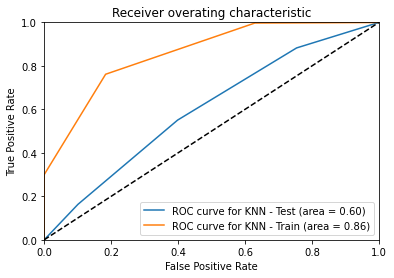

In [141]:
pl.clf()
pl.plot(fpr_tfidf_knn_test, tpr_tfidf_knn_test, label='ROC curve for KNN - Test (area = %0.2f)' % roc_auc_tfidf_knn_test)
pl.plot(fpr_tfidf_knn_train, tpr_tfidf_knn_train, label='ROC curve for KNN - Train (area = %0.2f)'
        % roc_auc_tfidf_knn_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver overating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model 5

# Naive Bayees for CV

In [134]:
gnb_cv = GaussianNB()
gnb_cv.fit(X_cv_train, y_cv_train)

GaussianNB()

In [135]:
cv_train_score = gnb_cv.score(X_cv_train,y_cv_train)

In [136]:
cv_train_score

0.6684921721531043

In [137]:
cv_test_score = gnb_cv.score(X_cv_test,y_cv_test)

In [138]:
cv_test_score

0.6021428571428571

### Metrics for CV - Naive Bayees

#### Confusion Matrix and Classification Report for Naive Bayees

In [139]:
predicted_cv_train = gnb_cv.predict(X_cv_train)

[[7191 1176]
 [4393 4039]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.86      0.72      8367
           1       0.77      0.48      0.59      8432

    accuracy                           0.67     16799
   macro avg       0.70      0.67      0.66     16799
weighted avg       0.70      0.67      0.66     16799



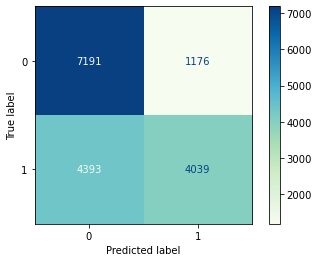

In [140]:
print(confusion_matrix(y_cv_train,predicted_cv_train))
print("-"*50)
print(plot_confusion_matrix(gnb_cv,X_cv_train,y_cv_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_train,predicted_cv_train))

In [141]:
predicted_cv_test = gnb_cv.predict(X_cv_test)

[[1618  515]
 [1156  911]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.76      0.66      2133
           1       0.64      0.44      0.52      2067

    accuracy                           0.60      4200
   macro avg       0.61      0.60      0.59      4200
weighted avg       0.61      0.60      0.59      4200



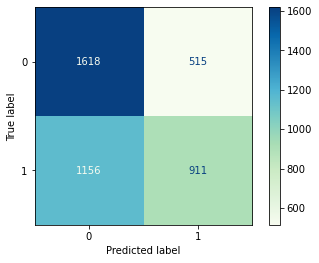

In [142]:
print(confusion_matrix(y_cv_test,predicted_cv_test))
print("-"*50)
print(plot_confusion_matrix(gnb_cv,X_cv_test,y_cv_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_test,predicted_cv_test))

#### ROC curve and Area under the curve for Naive Bayees

In [143]:
probas_cv_train = gnb_cv.predict_proba(X_cv_train)[:,1]
# Compute ROC curve and area the curve for nb
fpr_cv_train, tpr_cv_train, thresholds_cv_train = roc_curve(y_cv_train, predicted_cv_train)
roc_auc_cv_train = auc(fpr_cv_train, tpr_cv_train)
print("Area under the ROC curve : %f" % roc_auc_cv_train)

Area under the ROC curve : 0.669228


In [144]:
probas_cv_test = gnb_cv.predict_proba(X_cv_test)[:,1]
# Compute ROC curve and area the curve for nb
fpr_cv_test, tpr_cv_test, thresholds_cv_test = roc_curve(y_cv_test, predicted_cv_test)
roc_auc_cv_test = auc(fpr_cv_test, tpr_cv_test)
print("Area under the ROC curve : %f" % roc_auc_cv_test)

Area under the ROC curve : 0.599646


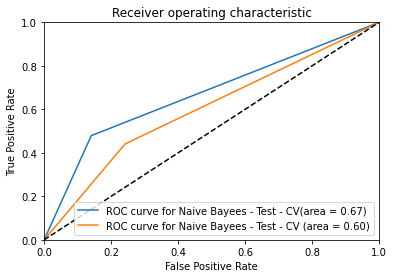

In [145]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_cv_train, tpr_cv_train, label='ROC curve for Naive Bayees - Test - CV(area = %0.2f)' % roc_auc_cv_train)
pl.plot(fpr_cv_test, tpr_cv_test, label='ROC curve for Naive Bayees - Test - CV (area = %0.2f)' % roc_auc_cv_test)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Naive Bayees for TFIDF

In [146]:
gnb_tfidf = GaussianNB()
gnb_tfidf.fit(X_tfidf_train, y_tfidf_train)

GaussianNB()

In [147]:
tfidf_train_score= gnb_tfidf.score(X_tfidf_train,y_tfidf_train)

In [148]:
tfidf_train_score

0.7651645931305435

In [149]:
tfidf_test_score =gnb_tfidf.score(X_tfidf_test,y_tfidf_test)

In [150]:
tfidf_test_score

0.6026190476190476

### Metrics for Naive Bayees - TFIDF 

#### Confusion Matrix and Classification Report for Naive Bayees

In [151]:
predicted_tfidf_train = gnb_tfidf.predict(X_tfidf_train)

[[6300 2067]
 [1878 6554]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      8367
           1       0.76      0.78      0.77      8432

    accuracy                           0.77     16799
   macro avg       0.77      0.77      0.77     16799
weighted avg       0.77      0.77      0.77     16799



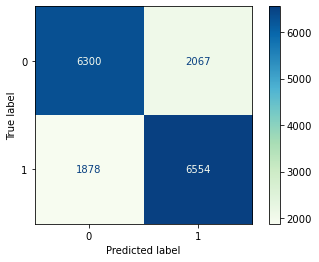

In [152]:
print(confusion_matrix(y_tfidf_train,predicted_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(gnb_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_tfidf_train))

In [153]:
predicted_tfidf_test = gnb_tfidf.predict(X_tfidf_test)

[[1268  865]
 [ 804 1263]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.59      0.60      2133
           1       0.59      0.61      0.60      2067

    accuracy                           0.60      4200
   macro avg       0.60      0.60      0.60      4200
weighted avg       0.60      0.60      0.60      4200



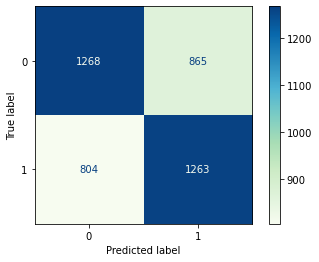

In [154]:
print(confusion_matrix(y_tfidf_test,predicted_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(gnb_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_tfidf_test))

#### ROC curve and Area under the curve for Naive Bayees

In [155]:
probas_tfidf_train = gnb_tfidf.predict_proba(X_tfidf_train)[:,1]
# Compute ROC curve and area the curve for nb
fpr_tfidf_train, tpr_tfidf_train, thresholds_tfidf_train = roc_curve(y_tfidf_train, predicted_tfidf_train)
roc_auc_tfidf_train = auc(fpr_tfidf_train, tpr_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_tfidf_train)

Area under the ROC curve : 0.765118


In [156]:
probas_tfidf_test = gnb_tfidf.predict_proba(X_tfidf_test)[:,1]
# Compute ROC curve and area the curve for nb
fpr_tfidf_test, tpr_tfidf_test, thresholds_tfidf_test = roc_curve(y_tfidf_test, predicted_tfidf_test)
roc_auc_tfidf_test = auc(fpr_tfidf_test, tpr_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_tfidf_test)

Area under the ROC curve : 0.602749


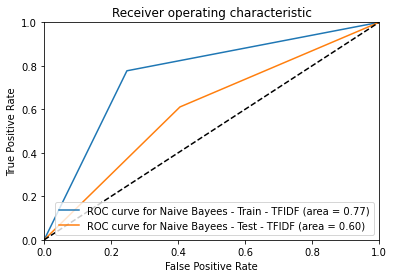

In [157]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_tfidf_train, tpr_tfidf_train, label='ROC curve for Naive Bayees - Train - TFIDF (area = %0.2f)' 
        % roc_auc_tfidf_train)
pl.plot(fpr_tfidf_test, tpr_tfidf_test, label='ROC curve for Naive Bayees - Test - TFIDF (area = %0.2f)' % roc_auc_tfidf_test)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model 6

# Gradient Boosting Classifier for CV

In [160]:
GB_cv = GradientBoostingClassifier(random_state = 42)
GB_cv.fit(X_cv_train,y_cv_train)

GradientBoostingClassifier(random_state=42)

In [161]:
print("Training Accuracy")
GB_cv.score(X_cv_train,y_cv_train)

Training Accuracy


0.6518840407167094

In [162]:
print("Testing Accuracy")
GB_cv.score(X_cv_test,y_cv_test)

Testing Accuracy


0.6009523809523809

### Metrics for GBBoost - CV

#### Confusion Matrix and Classification Report for Boosting 

In [163]:
predicted_GB_cv_train = GB_cv.predict(X_cv_train)
predicted_GB_cv_test = GB_cv.predict(X_cv_test)

[[5753 2614]
 [3234 5198]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      8367
           1       0.67      0.62      0.64      8432

    accuracy                           0.65     16799
   macro avg       0.65      0.65      0.65     16799
weighted avg       0.65      0.65      0.65     16799



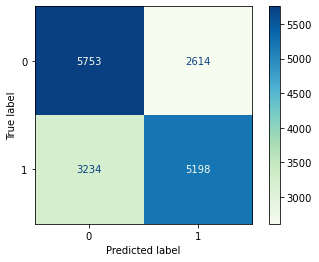

In [164]:
print(confusion_matrix(y_cv_train,predicted_GB_cv_train))
print("-"*50)
print(plot_confusion_matrix(GB_cv,X_cv_train,y_cv_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_train,predicted_GB_cv_train))

[[1353  780]
 [ 896 1171]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.63      0.62      2133
           1       0.60      0.57      0.58      2067

    accuracy                           0.60      4200
   macro avg       0.60      0.60      0.60      4200
weighted avg       0.60      0.60      0.60      4200



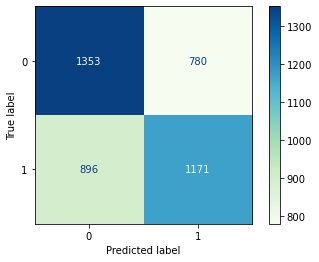

In [165]:
print(confusion_matrix(y_cv_test,predicted_GB_cv_test))
print("-"*50)
print(plot_confusion_matrix(GB_cv,X_cv_test,y_cv_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_test,predicted_GB_cv_test))

#### ROC curve and Area under the curve for Gradient Boosting

In [166]:
fpr_GB_cv_train, tpr_GB_cv_train, thresholds_GB_cv_train = roc_curve(y_cv_train, predicted_GB_cv_train)
roc_auc_GB_cv_train = auc(fpr_GB_cv_train, tpr_GB_cv_train)
print("Area under the ROC curve : %f" % roc_auc_GB_cv_train)

Area under the ROC curve : 0.652022


In [167]:
fpr_GB_cv_test, tpr_GB_cv_test, thresholds_GB_cv_test = roc_curve(y_cv_test, predicted_GB_cv_test)
roc_auc_GB_cv_test = auc(fpr_GB_cv_test, tpr_GB_cv_test)
print("Area under the ROC curve : %f" % roc_auc_GB_cv_test)

Area under the ROC curve : 0.600420


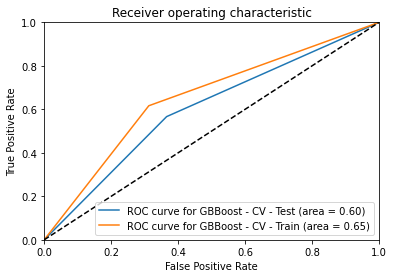

In [168]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_GB_cv_test, tpr_GB_cv_test, label='ROC curve for GBBoost - CV - Test (area = %0.2f)' % roc_auc_GB_cv_test)
pl.plot(fpr_GB_cv_train, tpr_GB_cv_train, label='ROC curve for GBBoost - CV - Train (area = %0.2f)' % roc_auc_GB_cv_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Gradient Boosting Classifier for TFIDF

In [169]:
GB_tfidf = GradientBoostingClassifier(random_state = 42)
GB_tfidf.fit(X_tfidf_train,y_tfidf_train)

GradientBoostingClassifier(random_state=42)

In [171]:
print("Training Accuracy")
GB_tfidf.score(X_tfidf_train,y_tfidf_train)

Training Accuracy


0.6830763735936662

In [172]:
print("Testing Accuracy")
GB_tfidf.score(X_tfidf_test,y_tfidf_test)

Testing Accuracy


0.6207142857142857

### Metrics for TFIDF- Gradient Boosting Classifier

#### Confusion Matrix and Classification Report for Gradient Boosting

In [173]:
predicted_GB_tfidf_train = GB_tfidf.predict(X_tfidf_train)
predicted_GB_tfidf_test = GB_tfidf.predict(X_tfidf_test)

[[5256 3111]
 [2213 6219]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.63      0.66      8367
           1       0.67      0.74      0.70      8432

    accuracy                           0.68     16799
   macro avg       0.69      0.68      0.68     16799
weighted avg       0.69      0.68      0.68     16799

--------------------------------------------------


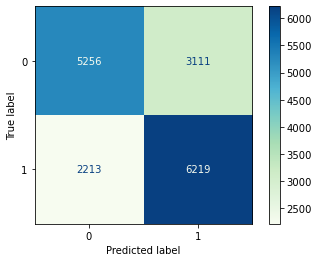

In [174]:
print(confusion_matrix(y_tfidf_train,predicted_GB_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(GB_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_GB_tfidf_train))
print("-"*50)

[[1207  926]
 [ 667 1400]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.57      0.60      2133
           1       0.60      0.68      0.64      2067

    accuracy                           0.62      4200
   macro avg       0.62      0.62      0.62      4200
weighted avg       0.62      0.62      0.62      4200



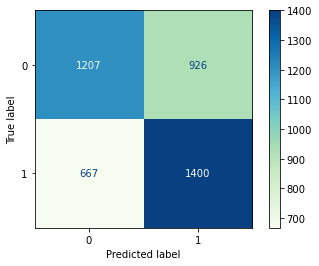

In [175]:
print(confusion_matrix(y_tfidf_test,predicted_GB_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(GB_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_GB_tfidf_test))

In [176]:
fpr_GB_tfidf_train, tpr_GB_tfidf_train, thresholds_GB_tfidf_train = roc_curve(y_tfidf_train, predicted_GB_tfidf_train)
roc_auc_GB_tfidf_train = auc(fpr_GB_tfidf_train, tpr_GB_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_GB_tfidf_train)

Area under the ROC curve : 0.682865


In [177]:
fpr_GB_tfidf_test, tpr_GB_tfidf_test, thresholds_GB_tfidf_test = roc_curve(y_tfidf_test, predicted_GB_tfidf_test)
roc_auc_GB_tfidf_test = auc(fpr_GB_tfidf_test, tpr_GB_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_GB_tfidf_test)

Area under the ROC curve : 0.621590


#### ROC curve and Area under the curve for Gradient Boosting Classifier

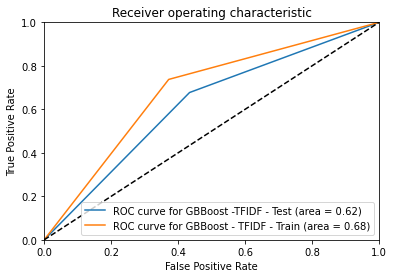

In [178]:
pl.clf()
pl.plot(fpr_GB_tfidf_test, tpr_GB_tfidf_test, label='ROC curve for GBBoost -TFIDF - Test (area = %0.2f)' 
        % roc_auc_GB_tfidf_test)
pl.plot(fpr_GB_tfidf_train, tpr_GB_tfidf_train, label='ROC curve for GBBoost - TFIDF - Train (area = %0.2f)' 
        % roc_auc_GB_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model 7

## Adaptive Boosting for CV

In [180]:
AB_cv=AdaBoostClassifier(base_estimator=RandomForestClassifier(),n_estimators=10,random_state=42)
AB_cv = AB_cv.fit(X_cv_train,y_cv_train)

In [181]:
print("Training Accuracy")
AB_cv.score(X_cv_train,y_cv_train)

Training Accuracy


1.0

In [182]:
print("Testing Accuracy")
AB_cv.score(X_cv_test,y_cv_test)

Testing Accuracy


0.6490476190476191

### Metrics for Adaptive Boosting - CV

#### Confusion Matrix and Classification Report for Adaboost 

In [183]:
predicted_AB_cv_train = AB_cv.predict(X_cv_train)
predicted_AB_cv_test = AB_cv.predict(X_cv_test)

[[8367    0]
 [   0 8432]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8367
           1       1.00      1.00      1.00      8432

    accuracy                           1.00     16799
   macro avg       1.00      1.00      1.00     16799
weighted avg       1.00      1.00      1.00     16799



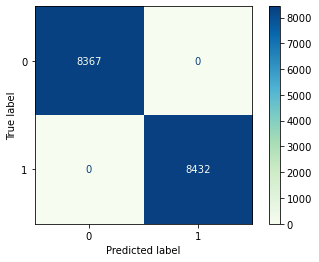

In [184]:
print(confusion_matrix(y_cv_train,predicted_AB_cv_train))
print("-"*50)
print(plot_confusion_matrix(AB_cv,X_cv_train,y_cv_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_train,predicted_AB_cv_train))

[[1346  787]
 [ 687 1380]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.63      0.65      2133
           1       0.64      0.67      0.65      2067

    accuracy                           0.65      4200
   macro avg       0.65      0.65      0.65      4200
weighted avg       0.65      0.65      0.65      4200



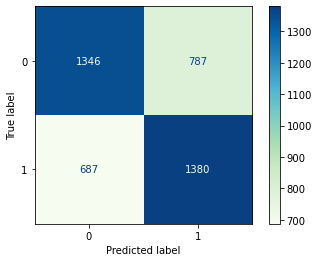

In [185]:
print(confusion_matrix(y_cv_test,predicted_AB_cv_test))
print("-"*50)
print(plot_confusion_matrix(AB_cv,X_cv_test,y_cv_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_test,predicted_AB_cv_test))

#### ROC curve and Area under the curve for AdaBoost CV

In [186]:
fpr_AB_cv_train, tpr_AB_cv_train, thresholds_AB_cv_train = roc_curve(y_cv_train, predicted_AB_cv_train)
roc_auc_AB_cv_train = auc(fpr_AB_cv_train, tpr_AB_cv_train)
print("Area under the ROC curve : %f" % roc_auc_AB_cv_train)

Area under the ROC curve : 1.000000


In [187]:
fpr_AB_cv_test, tpr_AB_cv_test, thresholds_AB_cv_test = roc_curve(y_cv_test, predicted_AB_cv_test)
roc_auc_AB_cv_test = auc(fpr_AB_cv_test, tpr_AB_cv_test)
print("Area under the ROC curve : %f" % roc_auc_AB_cv_test)

Area under the ROC curve : 0.649335


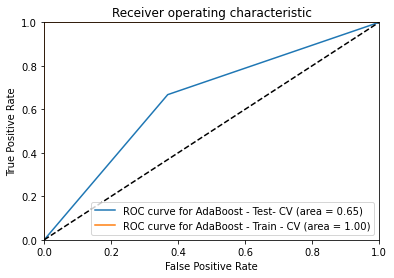

In [188]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_AB_cv_test, tpr_AB_cv_test, label='ROC curve for AdaBoost - Test- CV (area = %0.2f)' % roc_auc_AB_cv_test)
pl.plot(fpr_AB_cv_train, tpr_AB_cv_train, label='ROC curve for AdaBoost - Train - CV (area = %0.2f)' % roc_auc_AB_cv_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Adaptive Boosting   for TFIDF 

In [189]:
AB_tfidf=AdaBoostClassifier(base_estimator=RandomForestClassifier(),n_estimators=10,random_state=42)
AB_tfidf.fit(X_tfidf_train,y_tfidf_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(), n_estimators=10,
                   random_state=42)

In [190]:
print("Training Accuracy")
AB_tfidf.score(X_tfidf_train,y_tfidf_train)

Training Accuracy


1.0

In [191]:
print("Testing Accuracy")
AB_tfidf.score(X_tfidf_test,y_tfidf_test)

Testing Accuracy


0.6502380952380953

### Metrics for AdaBoost - TFIDF

#### Confusion Matrix and Classification Report for AdaBoost

In [192]:
predicted_AB_tfidf_train = AB_tfidf.predict(X_tfidf_train)
predicted_AB_tfidf_test = AB_tfidf.predict(X_tfidf_test)

[[8367    0]
 [   0 8432]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8367
           1       1.00      1.00      1.00      8432

    accuracy                           1.00     16799
   macro avg       1.00      1.00      1.00     16799
weighted avg       1.00      1.00      1.00     16799



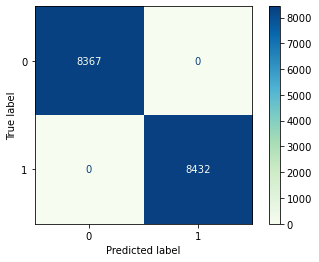

In [193]:
print(confusion_matrix(y_tfidf_train,predicted_AB_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(AB_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_AB_tfidf_train))

[[1415  718]
 [ 751 1316]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      2133
           1       0.65      0.64      0.64      2067

    accuracy                           0.65      4200
   macro avg       0.65      0.65      0.65      4200
weighted avg       0.65      0.65      0.65      4200



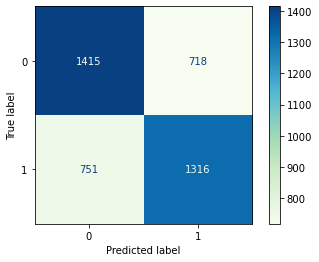

In [194]:
print(confusion_matrix(y_tfidf_test,predicted_AB_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(AB_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_AB_tfidf_test))

#### ROC curve and Area under the curve for AdaBoost 

In [195]:
# Compute ROC curve and area the curve
fpr_AB_tfidf_train, tpr_AB_tfidf_train, thresholds_AB_tfidf_train = roc_curve(y_tfidf_train, predicted_AB_tfidf_train)
roc_auc_AB_tfidf_train = auc(fpr_AB_tfidf_train, tpr_AB_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_AB_tfidf_train)

Area under the ROC curve : 1.000000


In [196]:
# Compute ROC curve and area the curve
fpr_AB_tfidf_test, tpr_AB_tfidf_test, thresholds_AB_tfidf_test = roc_curve(y_tfidf_test, predicted_AB_tfidf_test)
roc_auc_AB_tfidf_test = auc(fpr_AB_tfidf_test, tpr_AB_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_AB_tfidf_test)

Area under the ROC curve : 0.650028


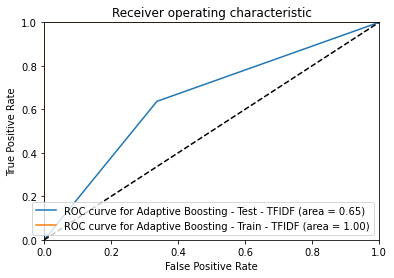

In [197]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_AB_tfidf_test, tpr_AB_tfidf_test, label='ROC curve for Adaptive Boosting - Test - TFIDF (area = %0.2f)'
        % roc_auc_AB_tfidf_test)
pl.plot(fpr_AB_tfidf_train, tpr_AB_tfidf_train, label='ROC curve for Adaptive Boosting - Train - TFIDF (area = %0.2f)' 
        % roc_auc_AB_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Hyper Paramter Tuning for Over Fitted Models

## Model 1 

### Hyper Parameter Tuning for Logistic Regression CV

In [3]:
param_grid = {}
cv = CountVectorizer(max_features=7000)
y_cv = df_clean['LABEL']
x_cv = cv.fit_transform(df_clean['CLEAN_TEXT']).toarray()
X_cv_train,X_cv_test,y_cv_train,y_cv_test=train_test_split(x_cv,y_cv,test_size=0.2,random_state=42)
param_grid= {'solver':('newton-cg', 'lbfgs', 'sag', 'saga'),'C': [0.01,0.05,0.1],'penalty':['l1', 'l2', 'elasticnet']}
gcv = GridSearchCV(estimator= LogisticRegression(n_jobs= -1),param_grid = param_grid)
gcv.fit(X_cv_train,y_cv_train)

GridSearchCV(estimator=LogisticRegression(n_jobs=-1),
             param_grid={'C': [0.01, 0.05, 0.1],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ('newton-cg', 'lbfgs', 'sag', 'saga')})

In [4]:
gcv.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

In [ ]:
lr = LogisticRegression(n_jobs= -1,C = 0.1,penalty = 'l2',solver = 'saga')
lr.fit(X_cv_train,y_cv_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr.score(X_cv_train,y_cv_train)

0.7564285714285715

In [ ]:
lr.score(X_cv_test,y_cv_test)

0.6404761904761904

### Metrics for CV - LogisticRegression

#### Confusion Matrix and Classification Report for Logistic Regression

[[6510 1875]
 [2217 6198]]
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      8385
           1       0.77      0.74      0.75      8415

    accuracy                           0.76     16800
   macro avg       0.76      0.76      0.76     16800
weighted avg       0.76      0.76      0.76     16800



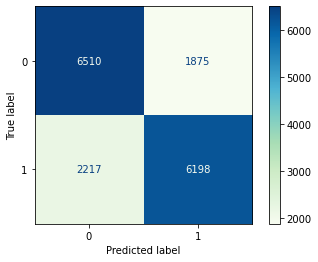

In [13]:
predicted_cv_train = lr.predict(X_cv_train)
print(confusion_matrix(y_cv_train,predicted_cv_train))
print(plot_confusion_matrix(lr,X_cv_train,y_cv_train, cmap = "GnBu",values_format="d"))
print(classification_report(y_cv_train,predicted_cv_train))

[[1403  712]
 [ 798 1287]]
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      2115
           1       0.64      0.62      0.63      2085

    accuracy                           0.64      4200
   macro avg       0.64      0.64      0.64      4200
weighted avg       0.64      0.64      0.64      4200



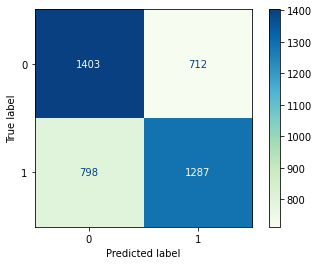

In [14]:
predicted_cv_test = lr.predict(X_cv_test)
print(confusion_matrix(y_cv_test,predicted_cv_test))
print(plot_confusion_matrix(lr,X_cv_test,y_cv_test, cmap = "GnBu",values_format="d"))
print(classification_report(y_cv_test,predicted_cv_test))

#### ROC curve and Area under the curve for Logistic Regression CV

In [ ]:
probas_cv_train = lr.predict_proba(X_cv_train)[:,1]
probas_cv_test = lr.predict_proba(X_cv_test)[:,1]

In [ ]:
fpr_cv_train, tpr_cv_train, thresholds_cv_train = roc_curve(y_cv_train, probas_cv_train)
roc_auc_cv_train = auc(fpr_cv_train, tpr_cv_train)
print("Area under the ROC curve : %f" % roc_auc_cv_train)

Area under the ROC curve : 0.844150


In [ ]:
fpr_tfidf_test, tpr_tfidf_test, thresholds_tfidf_test = roc_curve(y_tfidf_test, probas_tfidf_test[:, 1])
roc_auc_tfidf_test = auc(fpr_tfidf_test, tpr_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_tfidf_test)

In [ ]:
fpr_cv_test, tpr_cv_test, thresholds_cv_test = roc_curve(y_cv_test, probas_cv_test)
roc_auc_cv_test = auc(fpr_cv_test, tpr_cv_test)
print("Area under the ROC curve : %f" % roc_auc_cv_test)

Area under the ROC curve : 0.706508


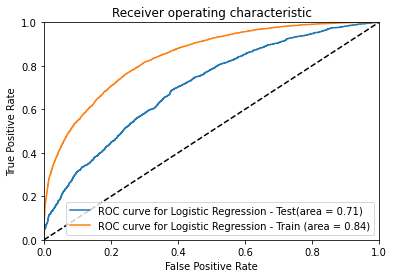

In [20]:
pl.clf()
pl.plot(fpr_cv_test, tpr_cv_test, label='ROC curve for Logistic Regression - Test(area = %0.2f)' % roc_auc_cv_test)
pl.plot(fpr_cv_train, tpr_cv_train, label='ROC curve for Logistic Regression - Train (area = %0.2f)' % roc_auc_cv_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Hyper Parameter Tuning for Logistic Regression TFIDF

In [39]:
param_grid= {'solver':('newton-cg', 'lbfgs', 'sag', 'saga'),'C': [0.01,0.05,0.1],'penalty':['l1', 'l2', 'elasticnet']}
gcv = GridSearchCV(estimator= LogisticRegression(n_jobs= -1),param_grid = param_grid)
gcv.fit(x_tfidf,y_tfidf)

GridSearchCV(estimator=LogisticRegression(n_jobs=-1),
             param_grid={'C': [0.01, 0.05, 0.1],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ('newton-cg', 'lbfgs', 'sag', 'saga')})

In [40]:
gcv.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

In [ ]:
LR_tfidf= LogisticRegression(penalty='l2', C=0.1,solver='newton-cg')
LR_tfidf.fit(X_tfidf_train,y_tfidf_train)

In [44]:
LR_tfidf.score(X_tfidf_train,y_tfidf_train)

0.7011904761904761

In [45]:
LR_tfidf1.score(X_tfidf_test,y_tfidf_test)

0.6485714285714286

### Metrics for TFIDF- LogisticRegression

#### Confusion Matrix and Classification Report for LogisticRegression


[[5782 2603]
 [2417 5998]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      8385
           1       0.70      0.71      0.70      8415

    accuracy                           0.70     16800
   macro avg       0.70      0.70      0.70     16800
weighted avg       0.70      0.70      0.70     16800



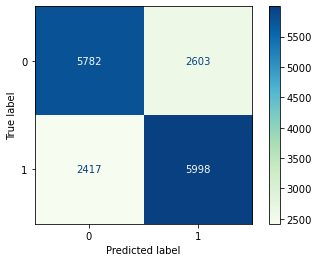

In [46]:
predicted_tfidf_train = LR_tfidf.predict(X_tfidf_train)
print(confusion_matrix(y_tfidf_train,predicted_tfidf_train))
print('-'*50)
print(plot_confusion_matrix(LR_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print(classification_report(y_tfidf_train,predicted_tfidf_train))

[[1334  781]
 [ 695 1390]]
              precision    recall  f1-score   support

           0       0.66      0.63      0.64      2115
           1       0.64      0.67      0.65      2085

    accuracy                           0.65      4200
   macro avg       0.65      0.65      0.65      4200
weighted avg       0.65      0.65      0.65      4200



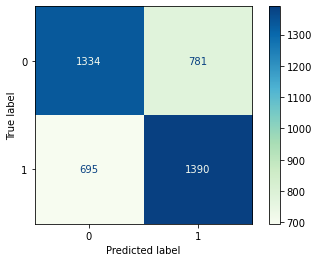

In [47]:
predicted_tfidf_test = LR_tfidf.predict(X_tfidf_test)
print(confusion_matrix(y_tfidf_test,predicted_tfidf_test))
print(plot_confusion_matrix(LR_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print(classification_report(y_tfidf_test,predicted_tfidf_test))

#### ROC curve and Area under the curve for Logistic Regression for TFIDF

In [48]:
probas_tfidf_train = LR_tfidf1.predict_proba(X_tfidf_train)
probas_tfidf_test = LR_tfidf1.predict_proba(X_tfidf_test)

In [49]:
fpr_tfidf_train, tpr_tfidf_train, thresholds_tfidf_train = roc_curve(y_tfidf_train, probas_tfidf_train[:, 1])
roc_auc_tfidf_train= auc(fpr_tfidf_train, tpr_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_tfidf_train)

Area under the ROC curve : 0.768006


In [50]:
fpr_tfidf_test, tpr_tfidf_test, thresholds_tfidf_test = roc_curve(y_tfidf_test, probas_tfidf_test[:, 1])
roc_auc_tfidf_test = auc(fpr_tfidf_test, tpr_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_tfidf_test)

Area under the ROC curve : 0.705987


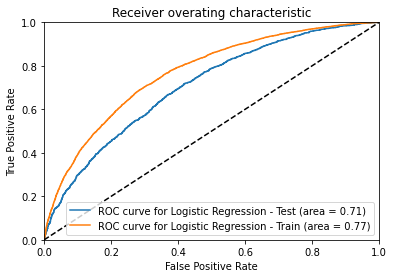

In [51]:
# Plot the ROC
pl.clf()
pl.plot(fpr_tfidf_test, tpr_tfidf_test, label='ROC curve for Logistic Regression - Test (area = %0.2f)' % roc_auc_tfidf_test)
pl.plot(fpr_tfidf_train, tpr_tfidf_train, label='ROC curve for Logistic Regression - Train (area = %0.2f)'
        % roc_auc_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model 2

## Hyper Parameter tuning for Decision Tree Classifier CV

In [121]:
tuned_paramaters = [{ 'max_depth': range(1, 5),
                     'min_samples_split': range(1,5),
                     'min_samples_leaf': range(1,5),
                     'max_leaf_nodes': range(1, 5)}]

decision_tree_classification = DecisionTreeClassifier(random_state = 42)

tree_grid = GridSearchCV(estimator = decision_tree_classification, 
                         
                         param_grid = tuned_paramaters, 
                         cv = 5)
tree_grid_model = tree_grid.fit(X_cv_train,y_cv_train)

print('Best parameters for decision tree classifier: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifier:  {'max_depth': 3, 'max_leaf_nodes': 4, 'min_samples_leaf': 1, 'min_samples_split': 2} 



In [ ]:
dt_cv= DecisionTreeClassifier(max_depth=3,max_leaf_nodes=4,min_samples_leaf=1,min_samples_split=2)
dt_cv.fit(X_cv_train,y_cv_train)

In [14]:
dt_cv.score(X_cv_train,y_cv_train)

0.5378571428571428

In [15]:
dt_cv.score(X_cv_test,y_cv_test)

0.5316666666666666

## Metrics for CV- Decision Tree 

#### Confusion Matrix and Classification Report for Decision Tree

[[1573 6812]
 [ 952 7463]]
              precision    recall  f1-score   support

           0       0.62      0.19      0.29      8385
           1       0.52      0.89      0.66      8415

    accuracy                           0.54     16800
   macro avg       0.57      0.54      0.47     16800
weighted avg       0.57      0.54      0.47     16800



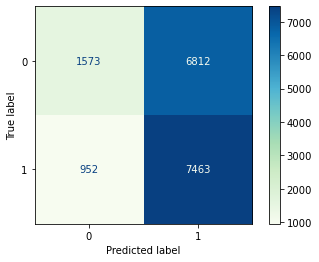

In [16]:
predicted_cv_train = dt_cv.predict(X_cv_train)
print(confusion_matrix(y_cv_train,predicted_cv_train))
print(plot_confusion_matrix(dt_cv,X_cv_train,y_cv_train, cmap = "GnBu"))
print(classification_report(y_cv_train,predicted_cv_train))

[[ 371 1744]
 [ 223 1862]]
              precision    recall  f1-score   support

           0       0.62      0.18      0.27      2115
           1       0.52      0.89      0.65      2085

    accuracy                           0.53      4200
   macro avg       0.57      0.53      0.46      4200
weighted avg       0.57      0.53      0.46      4200



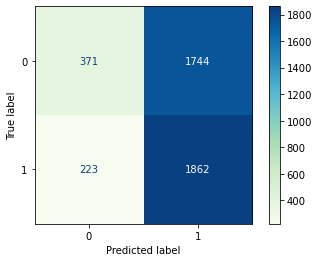

In [19]:
predicted_cv_test =dt_cv.predict(X_cv_test)
print(confusion_matrix(y_cv_test,predicted_cv_test))
print(plot_confusion_matrix(dt_cv,X_cv_test,y_cv_test, cmap = "GnBu"))
print(classification_report(y_cv_test,predicted_cv_test))

#### ROC curve and Area under the curve for DecissionTree for CV

In [23]:
probas_cv_train =dt_cv.predict_proba(X_cv_train)
probas_cv_test = dt_cv.predict_proba(X_cv_test)

In [24]:
fpr_cv_train, tpr_cv_train, thresholds_cv_train = roc_curve(y_cv_train, probas_cv_train[:, 1])
roc_auc_cv_train= auc(fpr_cv_train, tpr_cv_train)
print("Area under the ROC curve : %f" % roc_auc_cv_train)

Area under the ROC curve : 0.566212


In [26]:
fpr_cv_test, tpr_cv_test, thresholds_cv_test = roc_curve(y_cv_test, probas_cv_test[:, 1])
roc_auc_cv_test = auc(fpr_cv_test, tpr_cv_test)
print("Area under the ROC curve : %f" % roc_auc_cv_test)

Area under the ROC curve : 0.555022


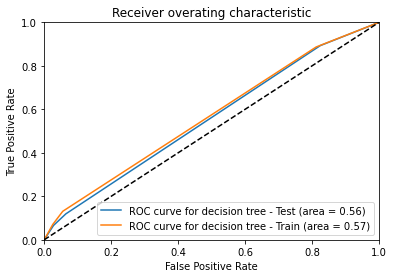

In [27]:
# Plot the ROC
pl.clf()
pl.plot(fpr_cv_test, tpr_cv_test, label='ROC curve for decision tree - Test (area = %0.2f)' % roc_auc_cv_test)
pl.plot(fpr_cv_train, tpr_cv_train, label='ROC curve for decision tree - Train (area = %0.2f)'
        % roc_auc_cv_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Hyper Paramter Tuning for Decision Tree TFIDF

In [121]:
tuned_paramaters = [{ 'max_depth': range(1, 5),
                     'min_samples_split': range(1,5),
                     'min_samples_leaf': range(1,5),
                     'max_leaf_nodes': range(1, 5)}]

decision_tree_classification = DecisionTreeClassifier(random_state = 42)

tree_grid = GridSearchCV(estimator = decision_tree_classification, 
                         
                         param_grid = tuned_paramaters, 
                         cv = 5)
tree_grid_model = tree_grid.fit(X_tfidf_train,y_tfidf_train)

print('Best parameters for decision tree classifier: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifier:  {'max_depth': 3, 'max_leaf_nodes': 4, 'min_samples_leaf': 1, 'min_samples_split': 2} 



In [33]:
dt_tfidf= DecisionTreeClassifier(max_depth=3,max_leaf_nodes=4,min_samples_leaf=1,min_samples_split=2)
dt_tfidf.fit(X_tfidf_train,y_tfidf_train)

In [34]:
dt_tfidf.score(X_tfidf_train,y_tfidf_train)

0.5654761904761905

In [35]:
dt_tfidf.score(X_tfidf_test,y_tfidf_test)

0.5604761904761905

### Metrics for TFIDF - Decision Tree 

#### Confusion Matrix and Classification Report for Decision Tree

[[2176 6209]
 [1091 7324]]
              precision    recall  f1-score   support

           0       0.67      0.26      0.37      8385
           1       0.54      0.87      0.67      8415

    accuracy                           0.57     16800
   macro avg       0.60      0.56      0.52     16800
weighted avg       0.60      0.57      0.52     16800



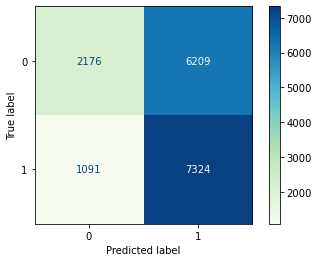

In [37]:
predicted_dt_train = dt_tfidf.predict(X_tfidf_train)
print(confusion_matrix(y_tfidf_train,predicted_dt_train))
print(plot_confusion_matrix(dt_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print(classification_report(y_tfidf_train,predicted_dt_train))

[[ 371 1744]
 [ 223 1862]]
              precision    recall  f1-score   support

           0       0.67      0.26      0.37      2115
           1       0.54      0.87      0.66      2085

    accuracy                           0.56      4200
   macro avg       0.60      0.56      0.52      4200
weighted avg       0.60      0.56      0.52      4200



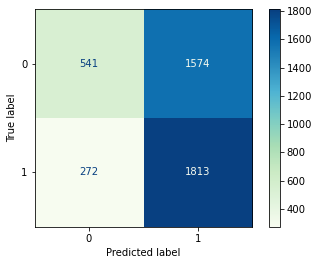

In [39]:
predicted_dt_test =dt_tfidf.predict(X_tfidf_test)
print(confusion_matrix(y_tfidf_test,predicted_cv_test))
print(plot_confusion_matrix(dt_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print(classification_report(y_tfidf_test,predicted_dt_test))

#### ROC curve and Area under the curve 

In [40]:
probas_tfidf_train =dt_tfidf.predict_proba(X_tfidf_train)
probas_tfidf_test = dt_tfidf.predict_proba(X_tfidf_test)

In [41]:
fpr_tfidf_train, tpr_tfidf_train, thresholds_tfidf_train = roc_curve(y_tfidf_train, probas_tfidf_train[:, 1])
roc_auc_tfidf_train= auc(fpr_tfidf_train, tpr_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_tfidf_train)

Area under the ROC curve : 0.579896


In [42]:
fpr_tfidf_test, tpr_tfidf_test, thresholds_tfidf_test = roc_curve(y_tfidf_test, probas_tfidf_test[:, 1])
roc_auc_tfidf_test = auc(fpr_tfidf_test, tpr_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_tfidf_test)

Area under the ROC curve : 0.576465


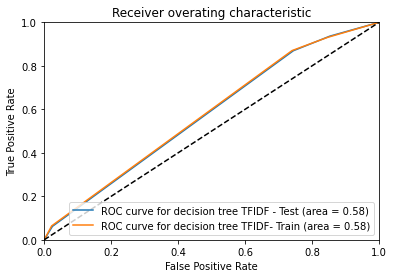

In [43]:
pl.clf()
pl.plot(fpr_tfidf_test, tpr_tfidf_test, label='ROC curve for decision tree TFIDF - Test (area = %0.2f)' % roc_auc_tfidf_test)
pl.plot(fpr_tfidf_train, tpr_tfidf_train, label='ROC curve for decision tree TFIDF- Train (area = %0.2f)'
        % roc_auc_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model 3

## Hyper Paramater Tuning for RandomForest CV

In [117]:
tuned_paramaters_cv = [{'criterion' : ['gini','entropy'],
                     'n_estimators': [120,140],
                     'max_depth': [50,60],
                     'min_samples_split': [5, 6, 7],
                     'min_samples_leaf': [8,10],
                     'max_leaf_nodes': [20,22]}]
 
rf_ht_cv = RandomForestClassifier(random_state = 10)

rf_grid_cv = GridSearchCV(estimator = rf_ht_cv, 
                       param_grid = tuned_paramaters, 
                       cv = 5)

rf_grid_model_cv = rf_grid_cv.fit(X_cv_train, y_cv_train)

print('Best parameters for random forest classifier: ', rf_grid_model_cv.best_params_)

Best parameters for random forest classifier:  {'criterion': 'gini', 'max_depth': 50, 'max_leaf_nodes': 22, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 140}


In [119]:
rf_cv_ht = RandomForestClassifier(n_estimators=140,criterion='gini', max_depth= 50, max_leaf_nodes= 22, 
                                  min_samples_leaf= 10, min_samples_split= 5,random_state=10)

In [120]:
rf_cv_ht.fit(X_cv_train,y_cv_train)

RandomForestClassifier(max_depth=50, max_leaf_nodes=22, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=140)

In [121]:
rf_cv_ht.score(X_cv_test,y_cv_test)

0.6126190476190476

### Metrics for CV- RandomForest

#### Confusion Matrix and Classification Report for Random Forest

In [122]:
predicted_rf_cv_ht_train = rf_cv_ht.predict(X_cv_train)
predicted_rf_cv_ht_test = rf_cv_ht.predict(X_cv_test)

[[1422  711]
 [ 916 1151]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.67      0.64      2133
           1       0.62      0.56      0.59      2067

    accuracy                           0.61      4200
   macro avg       0.61      0.61      0.61      4200
weighted avg       0.61      0.61      0.61      4200



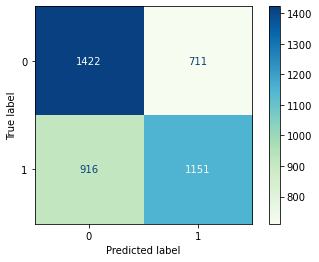

In [123]:
print(confusion_matrix(y_cv_test,predicted_rf_cv_ht_test))
print("-"*50)
print(plot_confusion_matrix(rf_cv_ht,X_cv_test,y_cv_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_test,predicted_rf_cv_ht_test))

[[5820 2547]
 [3447 4985]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.70      0.66      8367
           1       0.66      0.59      0.62      8432

    accuracy                           0.64     16799
   macro avg       0.64      0.64      0.64     16799
weighted avg       0.65      0.64      0.64     16799



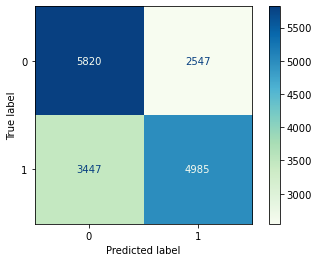

In [124]:
print(confusion_matrix(y_cv_train,predicted_rf_cv_ht_train))
print("-"*50)
print(plot_confusion_matrix(rf_cv_ht,X_cv_train,y_cv_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_train,predicted_rf_cv_ht_train))

#### ROC curve and Area under the curve for Random Forest HT

In [125]:
# Compute ROC curve and area the curve for logistic
fpr_rf_cv_ht_train, tpr_rf_cv_ht_train, thresholds_rf_cv_ht_train = roc_curve(y_cv_train, predicted_rf_cv_ht_train)
roc_auc_rf_cv_ht_train = auc(fpr_rf_cv_ht_train, tpr_rf_cv_ht_train)
print("Area under the ROC curve : %f" % roc_auc_rf_cv_ht_train)

Area under the ROC curve : 0.643395


In [126]:
# Compute ROC curve and area the curve for logistic
fpr_rf_cv_ht_test, tpr_rf_cv_ht_test, thresholds_rf_cv_ht_test = roc_curve(y_cv_test, predicted_rf_cv_ht_test)
roc_auc_rf_cv_ht_test = auc(fpr_rf_cv_ht_test, tpr_rf_cv_ht_test)
print("Area under the ROC curve : %f" % roc_auc_rf_cv_ht_test)

Area under the ROC curve : 0.611756


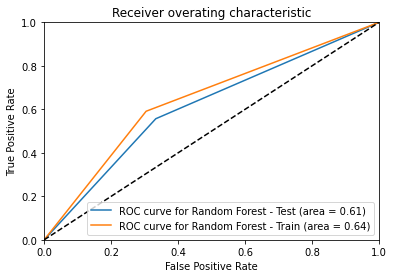

In [127]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_rf_cv_ht_test, tpr_rf_cv_ht_test, label='ROC curve for Random Forest HT - Test (area = %0.2f)' 
        % roc_auc_rf_cv_ht_test)
pl.plot(fpr_rf_cv_ht_train, tpr_rf_cv_ht_train, label='ROC curve for Random Forest HT - Train (area = %0.2f)' 
        % roc_auc_rf_cv_ht_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver overating characteristic')
pl.legend(loc="lower right")
pl.show()

## Hyper Parameter Tuning for Random Forest TFIDF 

In [ ]:
tuned_paramaters_tfidf = [{'criterion' : ['gini','entropy'],
                     'n_estimators': [120,140],
                     'max_depth': [50,60],
                     'min_samples_split': [5, 6, 7],
                     'min_samples_leaf': [8,10],
                     'max_leaf_nodes': [20,22]}]
 
rf_ht_tfidf = RandomForestClassifier(random_state = 42)

rf_grid_tfidf = GridSearchCV(estimator = rf_ht_tfidf, 
                       param_grid = tuned_paramaters, 
                       cv = 5)

rf_grid_model_tfidf = rf_grid_tfidf.fit(X_tfidf_train, y_tfidf_train)

print('Best parameters for random forest classifier: ', rf_grid_model_tfidf.best_params_, '\n')

Best parameters for random forest classifier:  {'criterion': 'entropy', 'max_depth': 50, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 140} 



In [133]:
rf_ht_tfidf= RandomForestClassifier(n_estimators=140,criterion= 'entropy', max_depth= 50, max_leaf_nodes=20, 
                                     min_samples_leaf= 10, min_samples_split= 5, random_state=10)

In [134]:
rf_ht_tfidf.fit(X_tfidf_train,y_tfidf_train)

RandomForestClassifier(criterion='entropy', max_depth=50, max_leaf_nodes=20,
                       min_samples_leaf=10, min_samples_split=5,
                       n_estimators=140, random_state=10)

In [135]:
rf_ht_tfidf.score(X_tfidf_test,y_tfidf_test)

0.6442857142857142

### Metrics for Random Forest HT - TFIDF

#### Confusion Matrix and Classification Report for Random Forest HT

In [136]:
predicted_rf_ht_tfidf_train = rf_ht_tfidf.predict(X_tfidf_train)
predicted_rf_ht_tfidf_test = rf_ht_tfidf.predict(X_tfidf_test)

[[1350  783]
 [ 711 1356]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.63      0.64      2133
           1       0.63      0.66      0.64      2067

    accuracy                           0.64      4200
   macro avg       0.64      0.64      0.64      4200
weighted avg       0.64      0.64      0.64      4200



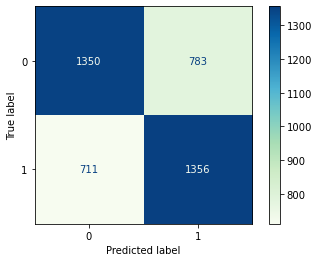

In [137]:
print(confusion_matrix(y_tfidf_test,predicted_rf_ht_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(rf_ht_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_rf_ht_tfidf_test))

[[5479 2888]
 [2645 5787]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      8367
           1       0.67      0.69      0.68      8432

    accuracy                           0.67     16799
   macro avg       0.67      0.67      0.67     16799
weighted avg       0.67      0.67      0.67     16799



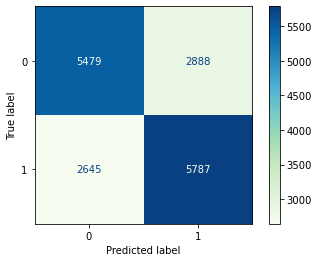

In [138]:
print(confusion_matrix(y_tfidf_train,predicted_rf_ht_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(rf_ht_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_rf_ht_tfidf_train))

#### ROC curve and Area under the curve for Random Forest HT

In [139]:
fpr_rf_ht_tfidf_train, tpr_rf_ht_tfidf_train, thresholds_rf_ht_tfidf_train = roc_curve(y_tfidf_train, 
                                                                                       predicted_rf_ht_tfidf_train)
roc_auc_rf_ht_tfidf_train = auc(fpr_rf_ht_tfidf_train, tpr_rf_ht_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_rf_ht_tfidf_train)

Area under the ROC curve : 0.670574


In [140]:
fpr_rf_ht_tfidf_test, tpr_rf_ht_tfidf_test, thresholds_rf_ht_tfidf_test = roc_curve(y_tfidf_test, predicted_rf_ht_tfidf_test)
roc_auc_rf_ht_tfidf_test = auc(fpr_rf_ht_tfidf_test, tpr_rf_ht_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_rf_ht_tfidf_test)

Area under the ROC curve : 0.644467


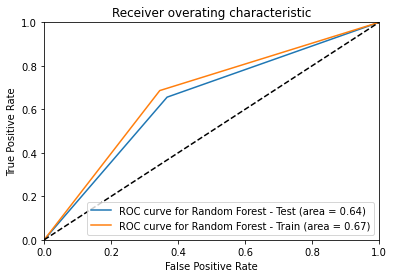

In [141]:
pl.clf()
pl.plot(fpr_rf_ht_tfidf_test, tpr_rf_ht_tfidf_test, label='ROC curve for Random Forest HT - Test (area = %0.2f)' 
        % roc_auc_rf_ht_tfidf_test)
pl.plot(fpr_rf_ht_tfidf_train, tpr_rf_ht_tfidf_train, label='ROC curve for Random Forest HT - Train (area = %0.2f)' 
        % roc_auc_rf_ht_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model 4

## Hyper Parameter for Adaptive Boosting CV

In [12]:
tuned_paramaters_cv = [{'n_estimators':[200,250,300],'learning_rate':[0.2,0.25,0.3]}]
 
ab_ht_cv = AdaBoostClassifier(random_state = 10)

ab_grid_cv = GridSearchCV(estimator = ab_ht_cv, 
                       param_grid = tuned_paramaters_cv, 
                       cv = 5)

ab_grid_model_cv = ab_grid_cv.fit(X_cv_train, y_cv_train)

print('Best parameters for adaptive boosting classifier: ', ab_grid_model_cv.best_params_)

Best parameters for adaptive boosting classifier:  {'learning_rate': 0.3, 'n_estimators': 300}


In [9]:
AB_cv=AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion= 'gini', max_depth= 50, max_leaf_nodes= 22, 
                                                               min_samples_leaf= 10, 
                                                               min_samples_split= 5),learning_rate= 0.3,
                                                               n_estimators= 300)

In [10]:
AB_cv.fit(X_cv_train,y_cv_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=50,
                                                         max_leaf_nodes=22,
                                                         min_samples_leaf=10,
                                                         min_samples_split=5),
                   learning_rate=0.3, n_estimators=300)

In [11]:
AB_cv.score(X_cv_test,y_cv_test)

0.6423809523809524

### Metrics for Adaptive Boosting - CV

#### Confusion Matrix and Classification Report for Adaptive Boosting

In [12]:
predicted_AB_cv_ht_train = AB_cv.predict(X_cv_train)
predicted_AB_cv_ht_test = AB_cv.predict(X_cv_test)

[[7021 1364]
 [1487 6928]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      8385
           1       0.84      0.82      0.83      8415

    accuracy                           0.83     16800
   macro avg       0.83      0.83      0.83     16800
weighted avg       0.83      0.83      0.83     16800



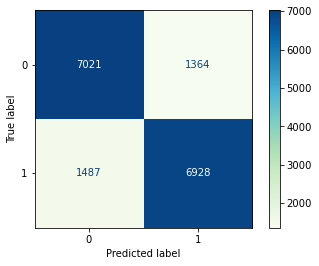

In [13]:
print(confusion_matrix(y_cv_train,predicted_AB_cv_ht_train))
print("-"*50)
print(plot_confusion_matrix(AB_cv,X_cv_train,y_cv_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_train,predicted_AB_cv_ht_train))

[[1374  741]
 [ 761 1324]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.65      0.65      2115
           1       0.64      0.64      0.64      2085

    accuracy                           0.64      4200
   macro avg       0.64      0.64      0.64      4200
weighted avg       0.64      0.64      0.64      4200



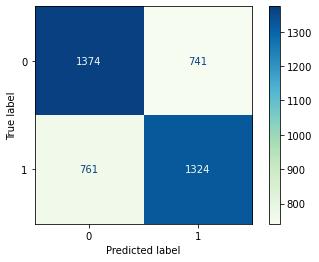

In [14]:
print(confusion_matrix(y_cv_test,predicted_AB_cv_ht_test))
print("-"*50)
print(plot_confusion_matrix(AB_cv,X_cv_test,y_cv_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_test,predicted_AB_cv_ht_test))

#### ROC curve and Area under the curve for Adaptive Boosting 

In [15]:
fpr_AB_cv_ht_train, tpr_AB_cv_ht_train, thresholds_AB_cv_ht_train = roc_curve(y_cv_train, 
                                                                                       predicted_AB_cv_ht_train)
roc_auc_AB_cv_ht_train = auc(fpr_AB_cv_ht_train, tpr_AB_cv_ht_train)
print("Area under the ROC curve : %f" % roc_auc_AB_cv_ht_train)

Area under the ROC curve : 0.830310


In [16]:
fpr_AB_cv_ht_test, tpr_AB_cv_ht_test, thresholds_AB_cv_ht_test = roc_curve(y_cv_test, 
                                                                                       predicted_AB_cv_ht_test)
roc_auc_AB_cv_ht_test = auc(fpr_AB_cv_ht_test, tpr_AB_cv_ht_test)
print("Area under the ROC curve : %f" % roc_auc_AB_cv_ht_test)

Area under the ROC curve : 0.642329


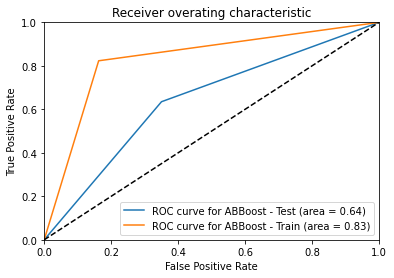

In [17]:
pl.clf()
pl.plot(fpr_AB_cv_ht_test, tpr_AB_cv_ht_test, label='ROC curve for ABBoost - Test (area = %0.2f)' 
        % roc_auc_AB_cv_ht_test)
pl.plot(fpr_AB_cv_ht_train, tpr_AB_cv_ht_train, label='ROC curve for ABBoost - Train (area = %0.2f)' 
        % roc_auc_AB_cv_ht_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver overating characteristic')
pl.legend(loc="lower right")
pl.show()

## Hyper Parameter for Adaptive Boosting TFIDF 

In [10]:
tuned_paramaters_tfidf = [{'n_estimators':[200,250,300],'learning_rate':[0.2,0.25,0.3]}]
 
ab_ht_tfidf = AdaBoostClassifier(random_state = 10)

ab_grid_tfidf = GridSearchCV(estimator = ab_ht_tfidf, 
                       param_grid = tuned_paramaters_tfidf, 
                       cv = 5)

ab_grid_model_tfidf = ab_grid_tfidf.fit(X_tfidf_train, y_tfidf_train)

print('Best parameters for adaptive boosting classifier: ', ab_grid_model_tfidf.best_params_)

Best parameters for adaptive boosting classifier:  {'learning_rate': 0.25, 'n_estimators': 300}


In [155]:
AB_tfidf_ht=AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion= 'entropy', 
                                                                  max_depth= 50, max_leaf_nodes=20,min_samples_leaf= 10, 
                                                                  min_samples_split= 5, random_state=10),
                            n_estimators=300,learning_rate=0.25,random_state=42)
AB_tfidf_ht.fit(X_tfidf_train,y_tfidf_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         max_depth=50,
                                                         max_leaf_nodes=20,
                                                         min_samples_leaf=10,
                                                         min_samples_split=5,
                                                         random_state=10),
                   learning_rate=0.25, n_estimators=300, random_state=42)

In [156]:
AB_tfidf_ht.score(X_tfidf_test,y_tfidf_test)

0.6528571428571428

### Metrics for Adaptive Boosting - TFIDF

#### Confusion Matrix and Classification Report for Adaptive Boosting

In [157]:
predicted_AB_tfidf_ht_train = AB_tfidf_ht.predict(X_tfidf_train)
predicted_AB_tfidf_ht_test = AB_tfidf_ht.predict(X_tfidf_test)

[[7401  966]
 [1039 7393]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      8367
           1       0.88      0.88      0.88      8432

    accuracy                           0.88     16799
   macro avg       0.88      0.88      0.88     16799
weighted avg       0.88      0.88      0.88     16799



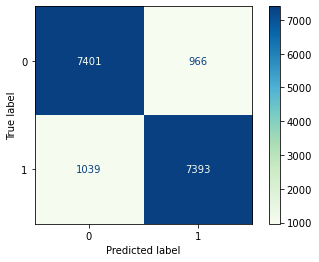

In [158]:
print(confusion_matrix(y_tfidf_train,predicted_AB_tfidf_ht_train))
print("-"*50)
print(plot_confusion_matrix(AB_tfidf_ht,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_AB_tfidf_ht_train))

[[1387  746]
 [ 712 1355]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      2133
           1       0.64      0.66      0.65      2067

    accuracy                           0.65      4200
   macro avg       0.65      0.65      0.65      4200
weighted avg       0.65      0.65      0.65      4200



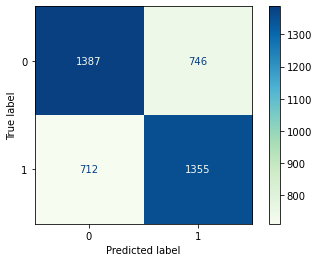

In [159]:
print(confusion_matrix(y_tfidf_test,predicted_AB_tfidf_ht_test))
print("-"*50)
print(plot_confusion_matrix(AB_tfidf_ht,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_AB_tfidf_ht_test))

#### ROC curve and Area under the curve for Adaptive boosting HT

In [160]:
fpr_AB_tfidf_ht_train, tpr_AB_tfidf_ht_train, thresholds_AB_tfidf_ht_train = roc_curve(y_tfidf_train, 
                                                                                       predicted_AB_tfidf_ht_train)
roc_auc_AB_tfidf_ht_train = auc(fpr_AB_tfidf_ht_train, tpr_AB_tfidf_ht_train)
print("Area under the ROC curve : %f" % roc_auc_AB_tfidf_ht_train)

Area under the ROC curve : 0.880663


In [161]:
fpr_AB_tfidf_ht_test, tpr_AB_tfidf_ht_test, thresholds_AB_tfidf_ht_test = roc_curve(y_tfidf_test, predicted_AB_tfidf_ht_test)
roc_auc_AB_tfidf_ht_test = auc(fpr_AB_tfidf_test, tpr_AB_tfidf_ht_test)
print("Area under the ROC curve : %f" % roc_auc_AB_tfidf_ht_test)

Area under the ROC curve : 0.652899


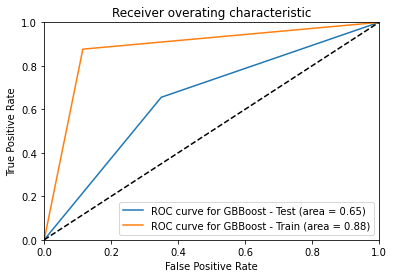

In [162]:
pl.clf()
pl.plot(fpr_AB_tfidf_ht_test, tpr_AB_tfidf_ht_test, label='ROC curve for ABBoost - Test (area = %0.2f)' 
        % roc_auc_AB_tfidf_ht_test)
pl.plot(fpr_AB_tfidf_ht_train, tpr_AB_tfidf_ht_train, label='ROC curve for ABBoost - Train (area = %0.2f)' 
        % roc_auc_AB_tfidf_ht_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver overating characteristic')
pl.legend(loc="lower right")
pl.show()

# Stacking Classfier 
#### Tuned Decision Tree and Tuned Random Forest as Base Estimator and Logistic Regression as Final Estimator

## For CV

In [9]:
rfc = RandomForestClassifier(criterion = 'gini', max_depth = 50, max_leaf_nodes = 22, min_samples_leaf = 10, 
                             min_samples_split = 5, n_estimators = 140,n_jobs =-1)
dt = DecisionTreeClassifier(max_depth =3, max_leaf_nodes = 4, min_samples_leaf = 1, min_samples_split =2)
estimators = (('rf',rfc),('dt',dt))
stack= StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_cv_train,y_cv_train)

StackingClassifier(estimators=(('rf',
                                RandomForestClassifier(max_depth=50,
                                                       max_leaf_nodes=22,
                                                       min_samples_leaf=10,
                                                       min_samples_split=5,
                                                       n_estimators=140,
                                                       n_jobs=-1)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=3,
                                                       max_leaf_nodes=4))),
                   final_estimator=LogisticRegression())

In [10]:
stack.score(X_cv_test,y_cv_test )

0.6176190476190476

In [11]:
stack.score(X_cv_train,y_cv_train )

0.6416071428571428

### Metrics for Stacking Classifier CV

#### Confusion Matrix and Classification Report 

In [12]:
predicted_stack_cv_test = stack.predict(X_cv_test)
predicted_stack_cv_train = stack.predict(X_cv_train)

[[5950 2435]
 [3586 4829]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      8385
           1       0.66      0.57      0.62      8415

    accuracy                           0.64     16800
   macro avg       0.64      0.64      0.64     16800
weighted avg       0.64      0.64      0.64     16800



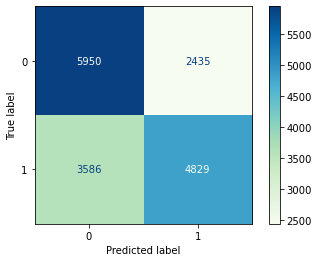

In [13]:
print(confusion_matrix(y_cv_train,predicted_stack_cv_train))
print("-"*50)
print(plot_confusion_matrix(stack,X_cv_train,y_cv_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_train,predicted_stack_cv_train))

[[1442  673]
 [ 933 1152]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.68      0.64      2115
           1       0.63      0.55      0.59      2085

    accuracy                           0.62      4200
   macro avg       0.62      0.62      0.62      4200
weighted avg       0.62      0.62      0.62      4200



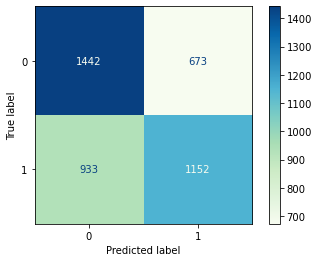

In [14]:
print(confusion_matrix(y_cv_test,predicted_stack_cv_test))
print("-"*50)
print(plot_confusion_matrix(stack,X_cv_test,y_cv_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_cv_test,predicted_stack_cv_test))

#### ROC curve and Area under the curve

In [15]:
fpr_stack_cv_train, tpr_stack_cv_train, thresholds_stack_cv_train = roc_curve(y_cv_train, 
                                                                                       predicted_stack_cv_train)
roc_auc_stack_cv_train = auc(fpr_stack_cv_train, tpr_stack_cv_train)
print("Area under the ROC curve : %f" % roc_auc_stack_cv_train)

Area under the ROC curve : 0.641728


In [16]:
fpr_stack_cv_test, tpr_stack_cv_test, thresholds_stack_cv_test = roc_curve(y_cv_test, 
                                                                                       predicted_stack_cv_test)
roc_auc_stack_cv_test = auc(fpr_stack_cv_test, tpr_stack_cv_test)
print("Area under the ROC curve : %f" % roc_auc_stack_cv_test)

Area under the ROC curve : 0.617157


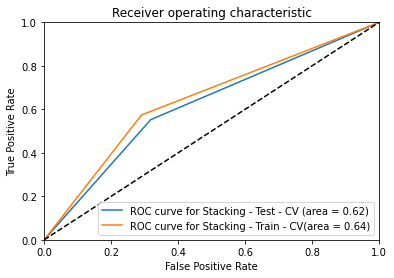

In [17]:
pl.clf()
pl.plot(fpr_stack_cv_test, tpr_stack_cv_test, label='ROC curve for Stacking - Test - CV (area = %0.2f)' 
        % roc_auc_stack_cv_test)
pl.plot(fpr_stack_cv_train, tpr_stack_cv_train, label='ROC curve for Stacking - Train - CV(area = %0.2f)' 
        % roc_auc_stack_cv_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

## For TFIDF

In [9]:
rfc = RandomForestClassifier(n_estimators = 140,criterion='entropy',max_depth=50,max_leaf_nodes=20,min_samples_leaf=10,
                             min_samples_split=5)
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=3,max_leaf_nodes=4,min_samples_leaf=1,min_samples_split=2)
estimators = (('rf',rfc),('dt',dt))
stack= StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_tfidf_train,y_tfidf_train)

StackingClassifier(estimators=(('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=50,
                                                       max_leaf_nodes=20,
                                                       min_samples_leaf=10,
                                                       min_samples_split=5,
                                                       n_estimators=140)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=3,
                                                       max_leaf_nodes=4))),
                   final_estimator=LogisticRegression())

In [10]:
stack.score(X_tfidf_train,y_tfidf_train)

0.6680357142857143

In [11]:
stack.score(X_tfidf_test,y_tfidf_test)

0.6345238095238095

### Metrics for Stacking Classifier - TFIDF

#### Confusion Matrix and Classification Report

In [12]:
predicted_stack_tfidf_test = stack.predict(X_tfidf_test)
predicted_stack_tfidf_train = stack.predict(X_tfidf_train)

[[5600 2785]
 [2792 5623]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      8385
           1       0.67      0.67      0.67      8415

    accuracy                           0.67     16800
   macro avg       0.67      0.67      0.67     16800
weighted avg       0.67      0.67      0.67     16800



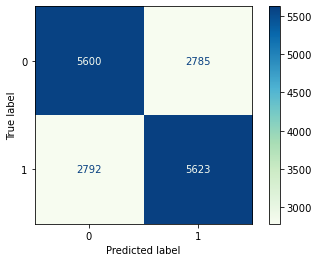

In [13]:
print(confusion_matrix(y_tfidf_train,predicted_stack_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(stack,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_stack_tfidf_train))

[[1327  788]
 [ 747 1338]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      2115
           1       0.63      0.64      0.64      2085

    accuracy                           0.63      4200
   macro avg       0.63      0.63      0.63      4200
weighted avg       0.63      0.63      0.63      4200



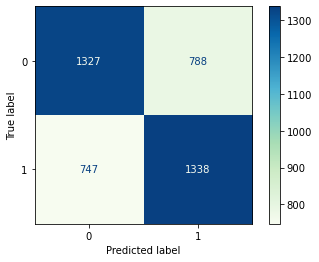

In [14]:
print(confusion_matrix(y_tfidf_test,predicted_stack_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(stack,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_stack_tfidf_test))

#### ROC curve and Area under the curve 

In [16]:
fpr_stack_tfidf_train, tpr_stack_tfidf_train, thresholds_stack_tfidf_train = roc_curve(y_tfidf_train, 
                                                                                       predicted_stack_tfidf_train)
roc_auc_stack_tfidf_train = auc(fpr_stack_tfidf_train, tpr_stack_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_stack_tfidf_train)

Area under the ROC curve : 0.668035


In [17]:
fpr_stack_tfidf_test, tpr_stack_tfidf_test, thresholds_stack_tfidf_test = roc_curve(y_tfidf_test, 
                                                                                       predicted_stack_tfidf_test)
roc_auc_stack_tfidf_test = auc(fpr_stack_tfidf_test, tpr_stack_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_stack_tfidf_test)

Area under the ROC curve : 0.634575


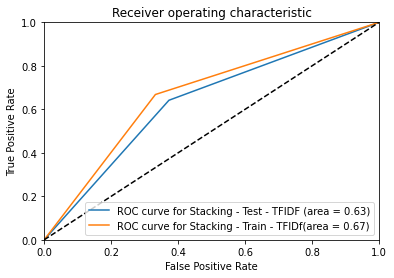

In [19]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_stack_tfidf_test, tpr_stack_tfidf_test, label='ROC curve for Stacking - Test - TFIDF (area = %0.2f)' 
        % roc_auc_stack_tfidf_test)
pl.plot(fpr_stack_tfidf_train, tpr_stack_tfidf_train, label='ROC curve for Stacking - Train - TFIDf(area = %0.2f)' 
        % roc_auc_stack_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

In [1]:
# Need to add scores for all - base models as well as Tuned models

# Next, we try to consider few other required columns from the dataset

#### Above, we observe that in all the models, TFIDF has always given us better results. So, For future reference we consider only TFIDF as vectorisation model

In [7]:
X = df.drop(['LABEL','DOC_ID','PRODUCT_ID','PRODUCT_TITLE','REVIEW_TITLE','REVIEW_TEXT'],axis =1)
Y = df['LABEL']

In [8]:
X.columns

Index(['RATING', 'VERIFIED_PURCHASE', 'PRODUCT_CATEGORY', 'CLEAN_TEXT'], dtype='object')

In [9]:
tfidf = TfidfVectorizer(max_features = 7000)
x_tfidf = pd.DataFrame(tfidf.fit_transform(X['CLEAN_TEXT']).toarray())

In [10]:
for i in ['RATING', 'VERIFIED_PURCHASE', 'PRODUCT_CATEGORY', 'CLEAN_TEXT']:
    x_tfidf[i] = X[i]

In [11]:
x_tfidf.drop('CLEAN_TEXT',axis=1,inplace=True)

In [12]:
x_tfidf.head(2)

,0,1,2,3,4,5,6,7,8,9,...,6993,6994,6995,6996,6997,6998,6999,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,N,PC
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Y,Wireless


# Dummy Encoding For Other required Columns

In [13]:
le = LabelEncoder()

In [14]:
y_tfidf = le.fit_transform(Y)

In [15]:
x_tfidf['VERIFIED_PURCHASE'] = le.fit_transform(x_tfidf['VERIFIED_PURCHASE'])

In [16]:
x_tfidf['PRODUCT_CATEGORY'] = le.fit_transform(x_tfidf['PRODUCT_CATEGORY'])

In [17]:
x_tfidf.head(2)

,0,1,2,3,4,5,6,7,8,9,...,6993,6994,6995,6996,6997,6998,6999,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,20
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,29


# Train Test Split

In [18]:
X_tfidf_train,X_tfidf_test,y_tfidf_train,y_tfidf_test=train_test_split(x_tfidf,y_tfidf,test_size=0.2,random_state=42)

In [19]:
x_tfidf.head(2)

,0,1,2,3,4,5,6,7,8,9,...,6993,6994,6995,6996,6997,6998,6999,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,20
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,29


In [20]:
y_tfidf

array([0, 0, 0, ..., 1, 1, 1])

# Model 1

## Logistic Regression

In [30]:
lr_tfidf = LogisticRegression()

In [31]:
lr_tfidf.fit(X_tfidf_train,y_tfidf_train)

LogisticRegression()

In [32]:
lr_tfidf.coef_

array([[ 1.12648813e+00,  1.03357087e-01,  8.47865799e-02, ...,
        -4.98568465e-02,  2.97573050e+00,  2.42790698e-03]])

In [33]:
lr_tfidf.intercept_

array([-1.69640234])

In [44]:
lr_tfidf.score(X_tfidf_train,y_tfidf_train)

0.8272619047619048

In [35]:
lr_tfidf.score(X_tfidf_test,y_tfidf_test)

0.7914285714285715

### Metrics for TF-IDF

#### Confusion Matrix and Classification Report for Logistic Regression

[[6745 1640]
 [1262 7153]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      8385
           1       0.81      0.85      0.83      8415

    accuracy                           0.83     16800
   macro avg       0.83      0.83      0.83     16800
weighted avg       0.83      0.83      0.83     16800



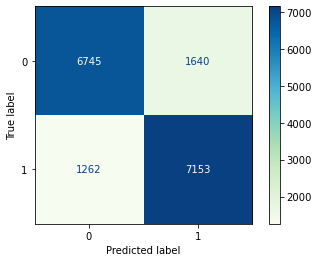

In [36]:
predicted_tfidf_train = lr_tfidf.predict(X_tfidf_train)
print(confusion_matrix(y_tfidf_train,predicted_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(lr_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_tfidf_train))

[[1634  481]
 [ 395 1690]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      2115
           1       0.78      0.81      0.79      2085

    accuracy                           0.79      4200
   macro avg       0.79      0.79      0.79      4200
weighted avg       0.79      0.79      0.79      4200



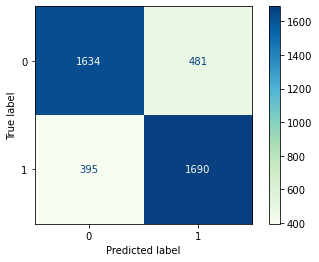

In [37]:
predicted_tfidf_test = lr_tfidf.predict(X_tfidf_test)
print(confusion_matrix(y_tfidf_test,predicted_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(lr_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_tfidf_test))

#### ROC curve and Area under the curve for Logistic Regression

In [38]:
probas_tfidf_train = lr_tfidf.predict_proba(X_tfidf_train)

In [39]:
probas_tfidf_test = lr_tfidf.predict_proba(X_tfidf_test)

In [40]:
fpr_tfidf_train, tpr_tfidf_train, thresholds_tfidf_train = roc_curve(y_tfidf_train, probas_tfidf_train[:, 1])
roc_auc_tfidf_train= auc(fpr_tfidf_train, tpr_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_tfidf_train)

Area under the ROC curve : 0.914101


In [41]:
fpr_tfidf_test, tpr_tfidf_test, thresholds_tfidf_test = roc_curve(y_tfidf_test, probas_tfidf_test[:, 1])
roc_auc_tfidf_test = auc(fpr_tfidf_test, tpr_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_tfidf_test)

Area under the ROC curve : 0.860195


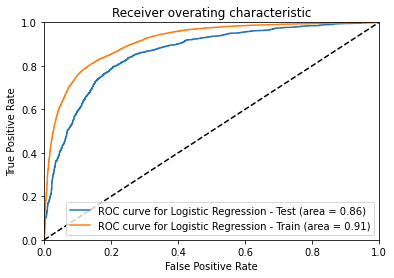

In [42]:
pl.clf()
pl.plot(fpr_tfidf_test, tpr_tfidf_test, label='ROC curve for Logistic Regression - Test (area = %0.2f)' % roc_auc_tfidf_test)
pl.plot(fpr_tfidf_train, tpr_tfidf_train, label='ROC curve for Logistic Regression - Train (area = %0.2f)'
        % roc_auc_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model 2

## Decision Tree

In [17]:
dt = DecisionTreeClassifier()
dt.fit(pd.get_dummies(X_tfidf_train,drop_first=True),y_tfidf_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [18]:
dt.score(pd.get_dummies(X_tfidf_test,drop_first= True),y_tfidf_test)

0.7292857142857143

In [19]:
dt.score(pd.get_dummies(X_tfidf_train,drop_first=True),y_tfidf_train)

1.0

### Feature Importance

In [ ]:
dt.feature_importances_[-1:-4:-1]

array([0.00081576, 0.        , 0.00017857])

## Metrics for Decision Tree

### Confusion Matrix and Classification Report

[[8385    0]
 [   0 8415]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8385
           1       1.00      1.00      1.00      8415

    accuracy                           1.00     16800
   macro avg       1.00      1.00      1.00     16800
weighted avg       1.00      1.00      1.00     16800



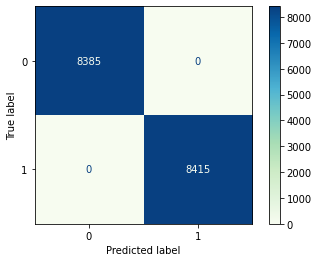

In [20]:
predicted_tfidf_train = dt.predict(pd.get_dummies(X_tfidf_train,drop_first=True))
print(confusion_matrix(y_tfidf_train,predicted_tfidf_train))
print(plot_confusion_matrix(dt,pd.get_dummies(X_tfidf_train,drop_first=True),y_tfidf_train, cmap = "GnBu",values_format="d"))
print(classification_report(y_tfidf_train,predicted_tfidf_train))

[[1545  570]
 [ 567 1518]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2115
           1       0.73      0.73      0.73      2085

    accuracy                           0.73      4200
   macro avg       0.73      0.73      0.73      4200
weighted avg       0.73      0.73      0.73      4200



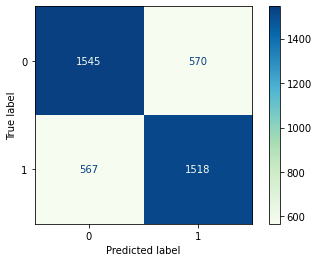

In [21]:
predicted_tfidf_test = dt.predict(pd.get_dummies(X_tfidf_test,drop_first=True))
print(confusion_matrix(y_tfidf_test,predicted_tfidf_test))
print(plot_confusion_matrix(dt,pd.get_dummies(X_tfidf_test,drop_first=True),y_tfidf_test, cmap = "GnBu",values_format="d"))
print(classification_report(y_tfidf_test,predicted_tfidf_test))

### ROC and Area Under the curve

In [22]:
probas_tfidf_train = dt.predict_proba(pd.get_dummies(X_tfidf_train,drop_first= True))
probas_tfidf_test = dt.predict_proba(pd.get_dummies(X_tfidf_test,drop_first= True))

In [23]:
fpr_tfidf_train, tpr_tfidf_train, thresholds_tfidf_train = roc_curve(y_tfidf_train, probas_tfidf_train[:, 1])
roc_auc_tfidf_train= auc(fpr_tfidf_train, tpr_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_tfidf_train)

Area under the ROC curve : 1.000000


In [27]:
fpr_tfidf_test, tpr_tfidf_test, thresholds_tfidf_test = roc_curve(y_tfidf_test, probas_tfidf_test[:, 1])
roc_auc_tfidf_test = auc(fpr_tfidf_test, tpr_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_tfidf_test)

Area under the ROC curve : 0.729277


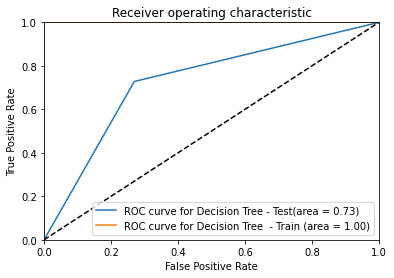

In [29]:
pl.clf()
pl.plot(fpr_tfidf_test, tpr_tfidf_test, label='ROC curve for Decision Tree - Test(area = %0.2f)' % roc_auc_tfidf_test)
pl.plot(fpr_tfidf_train, tpr_tfidf_train, label='ROC curve for Decision Tree  - Train (area = %0.2f)' % roc_auc_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Model 3

## Random Forest

In [42]:
rf_tfidf = RandomForestClassifier(random_state=10)

In [43]:
rf_tfidf.fit(X_tfidf_train,y_tfidf_train)

RandomForestClassifier(random_state=10)

In [44]:
print("Training Accuracy")
rf_tfidf.score(X_tfidf_train,y_tfidf_train)

Training Accuracy


1.0

In [45]:
print("Testing Accuracy")
rf_tfidf.score(X_tfidf_test,y_tfidf_test)

Testing Accuracy


0.8064285714285714

### Metrics for Random Forest - TFIDF

#### Confusion Matrix and Classification Report for Random Forest

In [46]:
predicted_rf_tfidf_train = rf_tfidf.predict(X_tfidf_train)
predicted_rf_tfidf_test = rf_tfidf.predict(X_tfidf_test)

[[8385    0]
 [   0 8415]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8385
           1       1.00      1.00      1.00      8415

    accuracy                           1.00     16800
   macro avg       1.00      1.00      1.00     16800
weighted avg       1.00      1.00      1.00     16800



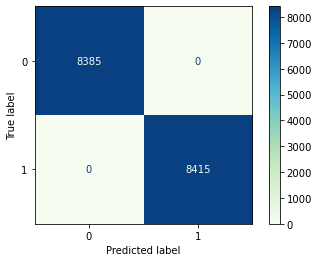

In [47]:
print(confusion_matrix(y_tfidf_train,predicted_rf_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(rf_tfidf,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_rf_tfidf_train))

[[1627  488]
 [ 325 1760]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      2115
           1       0.78      0.84      0.81      2085

    accuracy                           0.81      4200
   macro avg       0.81      0.81      0.81      4200
weighted avg       0.81      0.81      0.81      4200



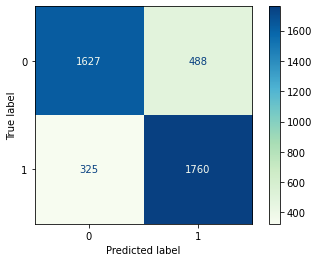

In [48]:
print(confusion_matrix(y_tfidf_test,predicted_rf_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(rf_tfidf,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_rf_tfidf_test))

#### ROC curve and Area under the curve for Random Forest

In [52]:
fpr_rf_tfidf_train, tpr_rf_tfidf_train, thresholds_rf_tfidf_train = roc_curve(y_tfidf_train, predicted_rf_tfidf_train)
roc_auc_rf_tfidf_train = auc(fpr_rf_tfidf_train, tpr_rf_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_rf_tfidf_train)

Area under the ROC curve : 1.000000


In [53]:
fpr_rf_tfidf_test, tpr_rf_tfidf_test, thresholds_rf_tfidf_test = roc_curve(y_tfidf_test, predicted_rf_tfidf_test)
roc_auc_rf_tfidf_test = auc(fpr_rf_tfidf_test, tpr_rf_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_rf_tfidf_test)

Area under the ROC curve : 0.806696


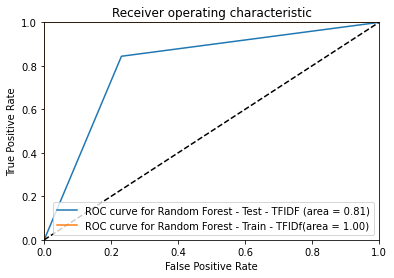

In [54]:
pl.clf()
pl.plot(fpr_rf_tfidf_test, tpr_rf_tfidf_test, label='ROC curve for Random Forest - Test - TFIDF (area = %0.2f)' 
        % roc_auc_rf_tfidf_test)
pl.plot(fpr_rf_tfidf_train, tpr_rf_tfidf_train, label='ROC curve for Random Forest - Train - TFIDf(area = %0.2f)' 
        % roc_auc_rf_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# Hyper Parameter Tuning for Over Fitted Model

## Decision Tree

In [ ]:
params =  [{'criterion': ['entropy', 'gini'], 'max_depth': [2,3,5,7,10]},
              {'min_samples_leaf': [1,2,3,4]},{'min_samples_split':[1,3,5,7,9]}]

In [ ]:
gcv = GridSearchCV(estimator = DecisionTreeClassifier() ,param_grid = params)

In [ ]:
gcv.fit(pd.get_dummies(X),Y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'criterion': ['entropy', 'gini'],
               

In [ ]:
gcv.best_params_

{'criterion': 'entropy', 'max_depth': 2}

In [30]:
dt = DecisionTreeClassifier(max_depth = 2,criterion= 'entropy')
dt.fit(pd.get_dummies(X_tfidf_train,drop_first=True),y_tfidf_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [33]:
dt.score(pd.get_dummies(X_tfidf_train,drop_first= True),y_tfidf_train)

0.7855952380952381

In [34]:
dt.score(pd.get_dummies(X_tfidf_test,drop_first= True),y_tfidf_test)

0.7728571428571429

## Metrics for Decision Tree

### Classification Report and Confusion Matrix 

[[6107 2278]
 [1324 7091]]
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      8385
           1       0.76      0.84      0.80      8415

    accuracy                           0.79     16800
   macro avg       0.79      0.79      0.78     16800
weighted avg       0.79      0.79      0.78     16800



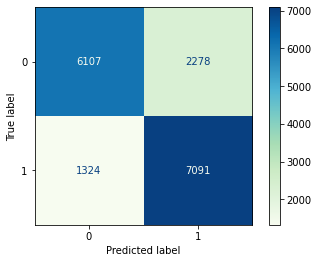

In [35]:
predicted_tfidf_train = dt.predict(pd.get_dummies(X_tfidf_train,drop_first=True))
print(confusion_matrix(y_tfidf_train,predicted_tfidf_train))
print(plot_confusion_matrix(dt,pd.get_dummies(X_tfidf_train,drop_first=True),y_tfidf_train, cmap = "GnBu",values_format="d"))
print(classification_report(y_tfidf_train,predicted_tfidf_train))

[[1516  599]
 [ 355 1730]]
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      2115
           1       0.74      0.83      0.78      2085

    accuracy                           0.77      4200
   macro avg       0.78      0.77      0.77      4200
weighted avg       0.78      0.77      0.77      4200



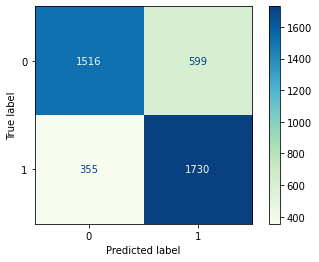

In [36]:
predicted_tfidf_test = dt.predict(pd.get_dummies(X_tfidf_test,drop_first=True))
print(confusion_matrix(y_tfidf_test,predicted_tfidf_test))
print(plot_confusion_matrix(dt,pd.get_dummies(X_tfidf_test,drop_first=True),y_tfidf_test, cmap = "GnBu",values_format="d"))
print(classification_report(y_tfidf_test,predicted_tfidf_test))

#### ROC and Area Under the curve for Decision Tree

In [37]:
probas_tfidf_train = dt.predict_proba(pd.get_dummies(X_tfidf_train,drop_first= True))
probas_tfidf_test = dt.predict_proba(pd.get_dummies(X_tfidf_test,drop_first= True))

In [38]:
# Compute ROC curve and area the curve for logistic
fpr_tfidf_train, tpr_tfidf_train, thresholds_tfidf_train = roc_curve(y_tfidf_train, probas_tfidf_train[:, 1])
roc_auc_tfidf_train= auc(fpr_tfidf_train, tpr_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_tfidf_train)

Area under the ROC curve : 0.815493


In [39]:
# Compute ROC curve and area the curve for logistic
fpr_tfidf_test, tpr_tfidf_test, thresholds_tfidf_test = roc_curve(y_tfidf_test, probas_tfidf_test[:, 1])
roc_auc_tfidf_test = auc(fpr_tfidf_test, tpr_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_tfidf_test)

Area under the ROC curve : 0.804806


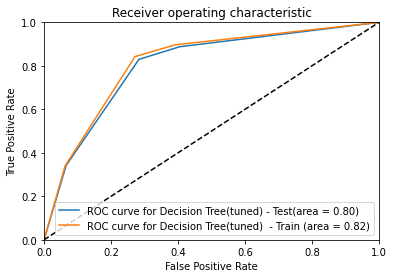

In [41]:
pl.clf()
pl.plot(fpr_tfidf_test, tpr_tfidf_test, label='ROC curve for Decision Tree(tuned) - Test(area = %0.2f)' % roc_auc_tfidf_test)
pl.plot(fpr_tfidf_train, tpr_tfidf_train, label='ROC curve for Decision Tree(tuned)  - Train (area = %0.2f)' % roc_auc_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

## Random Forest

In [21]:
tuned_paramaters_tfidf = [{'criterion' : ['gini','entropy'],
                     'n_estimators': [120,140],
                     'max_depth': [50,60],
                     'min_samples_split': [5, 6, 7],
                     'min_samples_leaf': [8,10],
                     'max_leaf_nodes': [20,22]}]
 
rf_ht_tfidf = RandomForestClassifier(random_state = 42)

rf_grid_tfidf = GridSearchCV(estimator = rf_ht_tfidf, 
                       param_grid = tuned_paramaters_tfidf, 
                       cv = 5)

rf_grid_model_tfidf = rf_grid_tfidf.fit(X_tfidf_train, y_tfidf_train)

print('Best parameters for random forest classifier: ', rf_grid_model_tfidf.best_params_, '\n')

Best parameters for random forest classifier:  {'criterion': 'gini', 'max_depth': 50, 'max_leaf_nodes': 22, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 140} 



# Random Forest With Tuned Parameters

In [19]:
rf_tfidf_ht = RandomForestClassifier(n_estimators=140,criterion='gini',max_depth=50,max_leaf_nodes=22,
                                     min_samples_leaf=10,min_samples_split=5,random_state=10)

In [75]:
rf_tfidf_ht.fit(X_tfidf_train,y_tfidf_train)

RandomForestClassifier(max_depth=50, max_leaf_nodes=22, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=140, random_state=10)

In [76]:
print("Training Accuracy")
rf_tfidf_ht.score(X_tfidf_train,y_tfidf_train)

Training Accuracy


0.8160714285714286

In [77]:
print("Testing Accuracy")
rf_tfidf_ht.score(X_tfidf_test,y_tfidf_test)

Testing Accuracy


0.7871428571428571

### Metrics for Random Forest - TFIDF - HT

#### Confusion Matrix and Classification Report for Random Forest HT

In [78]:
predicted_rf_tfidf_ht_train = rf_tfidf_ht.predict(X_tfidf_train)
predicted_rf_tfidf_ht_test = rf_tfidf_ht.predict(X_tfidf_test)

[[6511 1874]
 [1216 7199]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      8385
           1       0.79      0.86      0.82      8415

    accuracy                           0.82     16800
   macro avg       0.82      0.82      0.82     16800
weighted avg       0.82      0.82      0.82     16800



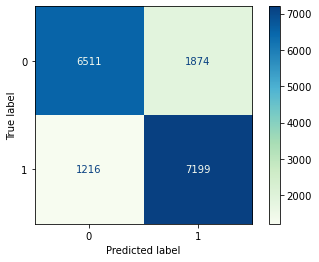

In [79]:
print(confusion_matrix(y_tfidf_train,predicted_rf_tfidf_ht_train))
print("-"*50)
print(plot_confusion_matrix(rf_tfidf_ht,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_rf_tfidf_ht_train))

[[1572  543]
 [ 351 1734]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      2115
           1       0.76      0.83      0.80      2085

    accuracy                           0.79      4200
   macro avg       0.79      0.79      0.79      4200
weighted avg       0.79      0.79      0.79      4200



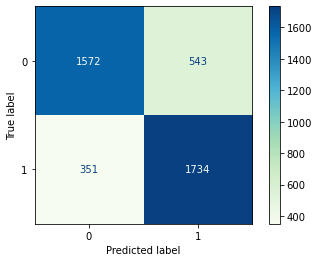

In [80]:
print(confusion_matrix(y_tfidf_test,predicted_rf_tfidf_ht_test))
print("-"*50)
print(plot_confusion_matrix(rf_tfidf_ht,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_rf_tfidf_ht_test))

#### ROC curve and Area under the curve for Random Forest

In [81]:
fpr_rf_tfidf_ht_train, tpr_rf_tfidf_ht_train, thresholds_rf_tfidf_ht_train = roc_curve(y_tfidf_train, 
                                                                                       predicted_rf_tfidf_ht_train)
roc_auc_rf_tfidf_ht_train = auc(fpr_rf_tfidf_ht_train, tpr_rf_tfidf_ht_train)
print("Area under the ROC curve : %f" % roc_auc_rf_tfidf_ht_train)

Area under the ROC curve : 0.816001


In [82]:
fpr_rf_tfidf_ht_test, tpr_rf_tfidf_ht_test, thresholds_rf_tfidf_ht_test = roc_curve(y_tfidf_test, predicted_rf_tfidf_ht_test)
roc_auc_rf_tfidf_ht_test = auc(fpr_rf_tfidf_ht_test, tpr_rf_tfidf_ht_test)
print("Area under the ROC curve : %f" % roc_auc_rf_tfidf_ht_test)

Area under the ROC curve : 0.787459


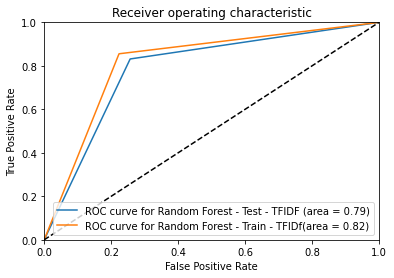

In [83]:
pl.clf()
pl.plot(fpr_rf_tfidf_ht_test, tpr_rf_tfidf_ht_test, label='ROC curve for Random Forest - Test - TFIDF (area = %0.2f)' 
        % roc_auc_rf_tfidf_ht_test)
pl.plot(fpr_rf_tfidf_ht_train, tpr_rf_tfidf_ht_train, label='ROC curve for Random Forest - Train - TFIDf(area = %0.2f)' 
        % roc_auc_rf_tfidf_ht_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

## Adaptive Boosting

In [ ]:
tuned_paramaters_tfidf = [{'n_estimators':[200,250,300],'learning_rate':[0.2,0.25,0.3]}]
 
ab_ht_tfidf = AdaBoostClassifier(random_state = 10)

ab_grid_tfidf = GridSearchCV(estimator = ab_ht_tfidf, 
                       param_grid = tuned_paramaters_tfidf, 
                       cv = 5)

ab_grid_model_tfidf = ab_grid_tfidf.fit(X_tfidf_train, y_tfidf_train)

print('Best parameters for adaptive boosting classifier: ', ab_grid_model_tfidf.best_params_)

Best parameters for adaptive boosting classifier:  {'learning_rate': 0.3, 'n_estimators': 300}


In [ ]:
AB_tfidf_ht=AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion= 'entropy', 
                                                                  max_depth= 50, max_leaf_nodes=20,min_samples_leaf= 10, 
                                                                  min_samples_split= 5, random_state=10),
                            n_estimators=300,learning_rate=0.3,random_state=10)
AB_tfidf_ht.fit(X_tfidf_train,y_tfidf_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=50,
                                                         max_features='auto',
                                                         max_leaf_nodes=20,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=10,
                                                         min_samples_split=5,
                                       

In [37]:
AB_tfidf_ht.score(X_tfidf_train,y_tfidf_train)

0.9315476190476191

In [ ]:
AB_tfidf_ht.score(X_tfidf_test,y_tfidf_test)

0.7995238095238095

## Metrics for Adaptive Boosting - TFIDF

#### Confusion Matrix and Classification Report for Adaptive Boosting

In [ ]:
predicted_AB_tfidf_ht_train = AB_tfidf_ht.predict(X_tfidf_train)
predicted_AB_tfidf_ht_test = AB_tfidf_ht.predict(X_tfidf_test)

[[7726  659]
 [ 491 7924]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      8385
           1       0.92      0.94      0.93      8415

    accuracy                           0.93     16800
   macro avg       0.93      0.93      0.93     16800
weighted avg       0.93      0.93      0.93     16800



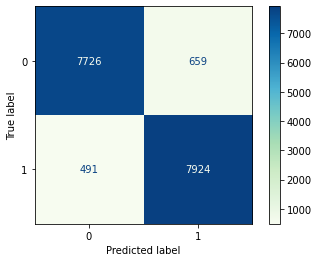

In [40]:
print(confusion_matrix(y_tfidf_train,predicted_AB_tfidf_ht_train))
print("-"*50)
print(plot_confusion_matrix(AB_tfidf_ht,X_tfidf_train,y_tfidf_train, cmap = "GnBu", values_format = 'd'))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_AB_tfidf_ht_train))

[[1667  448]
 [ 394 1691]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2115
           1       0.79      0.81      0.80      2085

    accuracy                           0.80      4200
   macro avg       0.80      0.80      0.80      4200
weighted avg       0.80      0.80      0.80      4200



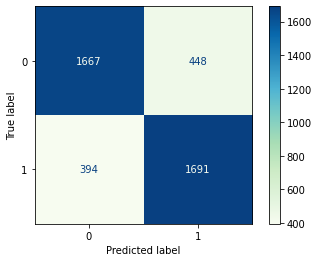

In [41]:
print(confusion_matrix(y_tfidf_test,predicted_AB_tfidf_ht_test))
print("-"*50)
print(plot_confusion_matrix(AB_tfidf_ht,X_tfidf_test,y_tfidf_test, cmap = "GnBu",values_format = 'd'))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_AB_tfidf_ht_test))

#### ROC curve and Area under the curve for Adaptive Boosting HT

In [ ]:
fpr_AB_tfidf_ht_train, tpr_AB_tfidf_ht_train, thresholds_AB_tfidf_ht_train = roc_curve(y_tfidf_train, 
                                                                                       predicted_AB_tfidf_ht_train)
roc_auc_AB_tfidf_ht_train = auc(fpr_AB_tfidf_ht_train, tpr_AB_tfidf_ht_train)
print("Area under the ROC curve : %f" % roc_auc_AB_tfidf_ht_train)

Area under the ROC curve : 0.931530


In [38]:
fpr_AB_tfidf_ht_test, tpr_AB_tfidf_ht_test, thresholds_AB_tfidf_ht_test = roc_curve(y_tfidf_test, predicted_AB_tfidf_ht_test)
roc_auc_AB_tfidf_ht_test = auc(fpr_AB_tfidf_ht_test, tpr_AB_tfidf_ht_test)
print("Area under the ROC curve : %f" % roc_auc_AB_tfidf_ht_test)

Area under the ROC curve : 0.799605


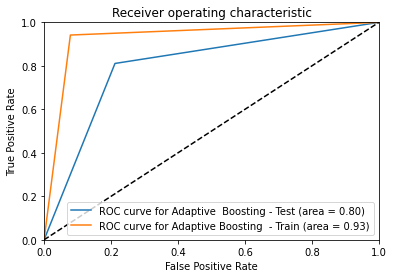

In [43]:
pl.clf()
pl.plot(fpr_AB_tfidf_ht_test, tpr_AB_tfidf_ht_test, label='ROC curve for Adaptive  Boosting - Test (area = %0.2f)' 
        % roc_auc_AB_tfidf_ht_test)
pl.plot(fpr_AB_tfidf_ht_train, tpr_AB_tfidf_ht_train, label='ROC curve for Adaptive Boosting  - Train (area = %0.2f)' 
        % roc_auc_AB_tfidf_ht_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

## Stacking Classifier

In [7]:
rfc = RandomForestClassifier(n_estimators=140,criterion='gini',max_depth=50,max_leaf_nodes=22,
                                     min_samples_leaf=10,min_samples_split=5,random_state=10)
lr = LogisticRegression()
dt = DecisionTreeClassifier(criterion='entropy',max_depth=2)
estimators = (('rf',rfc),('dt',dt),('lr',lr))
stack= StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_tfidf_train,y_tfidf_train)

StackingClassifier(estimators=(('rf',
                                RandomForestClassifier(max_depth=50,
                                                       max_leaf_nodes=22,
                                                       min_samples_leaf=10,
                                                       min_samples_split=5,
                                                       n_estimators=140,
                                                       random_state=10)),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=2)),
                               ('lr', LogisticRegression())),
                   final_estimator=LogisticRegression())

In [8]:
stack.score(X_tfidf_train,y_tfidf_train)

0.7481547619047619

In [9]:
stack.score(X_tfidf_test,y_tfidf_test)

0.6561904761904762

### Metrics for Stacking Classifier

#### Classification Report and Confusion Matrix

In [10]:
predicted_stack_tfidf_test = stack.predict(X_tfidf_test)
predicted_stack_tfidf_train = stack.predict(X_tfidf_train)

[[6267 2118]
 [2113 6302]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      8385
           1       0.75      0.75      0.75      8415

    accuracy                           0.75     16800
   macro avg       0.75      0.75      0.75     16800
weighted avg       0.75      0.75      0.75     16800



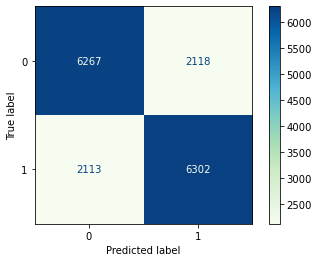

In [11]:
print(confusion_matrix(y_tfidf_train,predicted_stack_tfidf_train))
print("-"*50)
print(plot_confusion_matrix(stack,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_stack_tfidf_train))

[[1382  733]
 [ 711 1374]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      2115
           1       0.65      0.66      0.66      2085

    accuracy                           0.66      4200
   macro avg       0.66      0.66      0.66      4200
weighted avg       0.66      0.66      0.66      4200



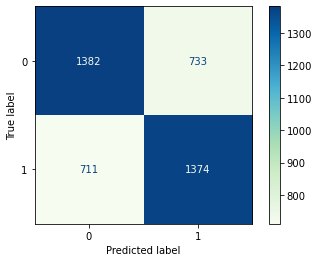

In [12]:
print(confusion_matrix(y_tfidf_test,predicted_stack_tfidf_test))
print("-"*50)
print(plot_confusion_matrix(stack,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_stack_tfidf_test))

#### ROC and Area Under the Curve

In [13]:
fpr_stack_tfidf_train, tpr_stack_tfidf_train, thresholds_stack_tfidf_train = roc_curve(y_tfidf_train, 
                                                                                       predicted_stack_tfidf_train)
roc_auc_stack_tfidf_train = auc(fpr_stack_tfidf_train, tpr_stack_tfidf_train)
print("Area under the ROC curve : %f" % roc_auc_stack_tfidf_train)

Area under the ROC curve : 0.748153


In [14]:
fpr_stack_tfidf_test, tpr_stack_tfidf_test, thresholds_stack_tfidf_test = roc_curve(y_tfidf_test, 
                                                                                       predicted_stack_tfidf_test)
roc_auc_stack_tfidf_test = auc(fpr_stack_tfidf_test, tpr_stack_tfidf_test)
print("Area under the ROC curve : %f" % roc_auc_stack_tfidf_test)

Area under the ROC curve : 0.656210


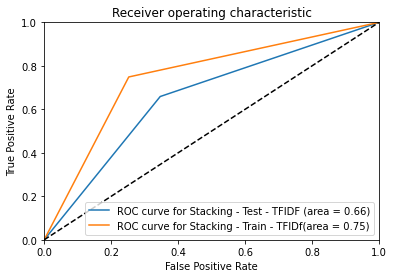

In [15]:
# Plot ROC curve
pl.clf()
pl.plot(fpr_stack_tfidf_test, tpr_stack_tfidf_test, label='ROC curve for Stacking - Test - TFIDF (area = %0.2f)' 
        % roc_auc_stack_tfidf_test)
pl.plot(fpr_stack_tfidf_train, tpr_stack_tfidf_train, label='ROC curve for Stacking - Train - TFIDf(area = %0.2f)' 
        % roc_auc_stack_tfidf_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

## Voting Classifier

In [32]:
rfc = RandomForestClassifier(n_estimators = 140,criterion= 'gini', max_depth = 50, max_leaf_nodes = 22, min_samples_leaf = 10,
                              min_samples_split = 5)
lr = LogisticRegression()
dt = DecisionTreeClassifier(criterion= 'entropy',max_depth = 2)
model = VotingClassifier(estimators = [('rf',rfc),('lr',lr),('dt',dt)],voting = 'soft')
#model.fit(X_tfidf_train,y_tfidf_train)

In [23]:
model.score(X_tfidf_train,y_tfidf_train)

0.7951190476190476

In [24]:
model.score(X_tfidf_test,y_tfidf_test)

0.7797619047619048

### Metrics for Voting

#### Confusion Matrix and Classification Report 

In [25]:
predicted_voting_tfidf_ht_train = model.predict(X_tfidf_train)
predicted_voting_tfidf_ht_test = model.predict(X_tfidf_test)

[[6226 2159]
 [1283 7132]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      8385
           1       0.77      0.85      0.81      8415

    accuracy                           0.80     16800
   macro avg       0.80      0.80      0.79     16800
weighted avg       0.80      0.80      0.79     16800



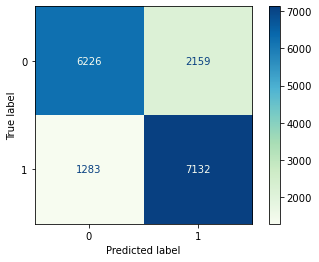

In [26]:
print(confusion_matrix(y_tfidf_train,predicted_voting_tfidf_ht_train))
print("-"*50)
print(plot_confusion_matrix(model,X_tfidf_train,y_tfidf_train, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_train,predicted_voting_tfidf_ht_train))

[[1538  577]
 [ 348 1737]]
--------------------------------------------------
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      2115
           1       0.75      0.83      0.79      2085

    accuracy                           0.78      4200
   macro avg       0.78      0.78      0.78      4200
weighted avg       0.78      0.78      0.78      4200



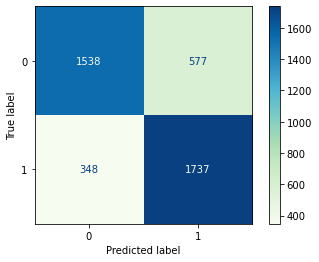

In [27]:
print(confusion_matrix(y_tfidf_test,predicted_voting_tfidf_ht_test))
print("-"*50)
print(plot_confusion_matrix(model,X_tfidf_test,y_tfidf_test, cmap = "GnBu"))
print("-"*50)
print(classification_report(y_tfidf_test,predicted_voting_tfidf_ht_test))

#### ROC curve and Area under the curve

In [28]:
fpr_voting_tfidf_ht_train, tpr_voting_tfidf_ht_train, thresholds_voting_tfidf_ht_train = roc_curve(y_tfidf_train, 
                                                                                       predicted_voting_tfidf_ht_train)
roc_auc_voting_tfidf_ht_train = auc(fpr_voting_tfidf_ht_train, tpr_voting_tfidf_ht_train)
print("Area under the ROC curve : %f" % roc_auc_voting_tfidf_ht_train)

Area under the ROC curve : 0.795025


In [29]:
fpr_voting_tfidf_ht_test, tpr_voting_tfidf_ht_test, thresholds_vooting_tfidf_ht_test = roc_curve(y_tfidf_test, 
                                                                                                 predicted_voting_tfidf_ht_test)
roc_auc_voting_tfidf_ht_test = auc(fpr_voting_tfidf_ht_test, tpr_voting_tfidf_ht_test)
print("Area under the ROC curve : %f" % roc_auc_voting_tfidf_ht_test)

Area under the ROC curve : 0.780140


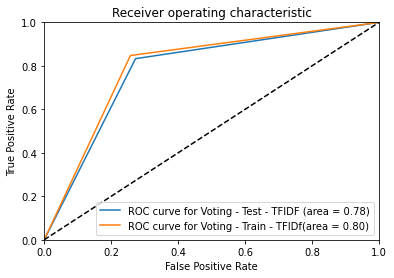

In [30]:
pl.clf()
pl.plot(fpr_voting_tfidf_ht_test, tpr_voting_tfidf_ht_test, label='ROC curve for Voting - Test - TFIDF (area = %0.2f)' 
        % roc_auc_voting_tfidf_ht_test)
pl.plot(fpr_voting_tfidf_ht_train, tpr_voting_tfidf_ht_train, label='ROC curve for Voting - Train - TFIDf(area = %0.2f)' 
        % roc_auc_voting_tfidf_ht_train)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

# KFold Cross Validation for the Tuned Models to check Robustness

## Logistic Regression

In [31]:
kf = KFold(n_splits = 10,shuffle=True, random_state=10)

In [33]:
scores = cross_val_score(estimator = LogisticRegression(), 
                         X = x_tfidf, 
                         y = y_tfidf, 
                         cv = kf, 
                        scoring = 'accuracy')

In [35]:
scores_f1 = cross_val_score(estimator = LogisticRegression(), 
                         X = x_tfidf, 
                         y = y_tfidf, 
                         cv = kf, 
                        scoring = 'f1')

In [36]:
scores_roc = cross_val_score(estimator = LogisticRegression(), 
                         X = x_tfidf, 
                         y = y_tfidf, 
                         cv = kf, 
                        scoring = 'roc_auc')

In [54]:
Scoring = pd.DataFrame(data=[scores ,scores_f1,scores_roc],index=['Accuracy','f1_score','roc_auc']).T    
Scoring

,Accuracy,f1_score,roc_auc
0,0.794286,0.795261,0.867482
1,0.809048,0.812178,0.864839
2,0.799048,0.803355,0.862233
3,0.802857,0.803977,0.874714
4,0.804762,0.807692,0.874356
5,0.802381,0.803224,0.863425
6,0.800476,0.805929,0.860806
7,0.815238,0.825540,0.878805
8,0.802857,0.811647,0.862321
9,0.800476,0.805026,0.871097


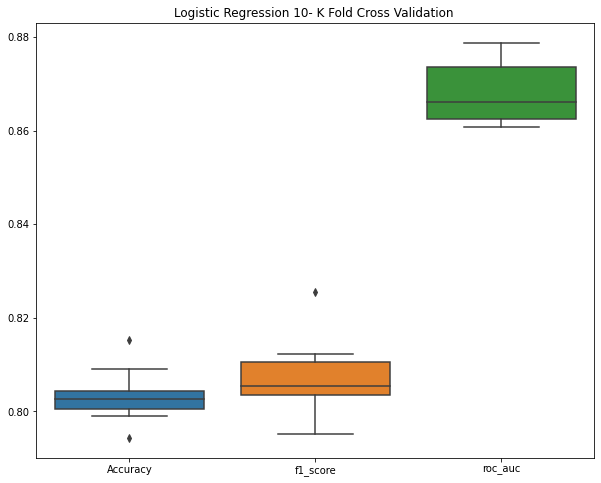

In [55]:
plt.figure(figsize=(10,8))
sns.boxplot(data=Scoring)
plt.title('Logistic Regression 10- K Fold Cross Validation ')
plt.show()

## Decision Tree

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 2)
accuracies = []
f1_scores = []
roc_auc_scores =[]
x_tfidf = pd.get_dummies(x_tfidf,drop_first = True)
for train_ix, test_ix in kfold.split(x_tfidf,Y):
    train_X, test_X = x_tfidf.loc[train_ix],x_tfidf.loc[test_ix]
    train_y, test_y = Y.loc[train_ix],Y.loc[test_ix]
    dt.fit(pd.get_dummies(train_X,drop_first= True),train_y)
    y_pred = dt.predict(test_X)
    accuracies.append(dt.score(pd.get_dummies(test_X,drop_first= True),test_y))
    f1_scores.append(f1_score(test_y,y_pred))
    probas_tfidf_test = dt.predict_proba(test_X)[:,1]
    roc_auc_scores.append(roc_auc_score(test_y,probas_tfidf_test))

In [ ]:
accuracies

[0.7785714285714286,
 0.7757142857142857,
 0.7852380952380953,
 0.7714285714285715,
 0.7752380952380953,
 0.7814285714285715,
 0.7995238095238095,
 0.79,
 0.7823809523809524,
 0.790952380952381]

In [ ]:
f1_scores

[0.7883477469276287,
 0.7840440165061898,
 0.7935926773455377,
 0.788546255506608,
 0.7909654561558902,
 0.7987724682156949,
 0.8159160472234368,
 0.7959278111985192,
 0.7902707664066085,
 0.8003638017280582]

In [ ]:
roc_auc_scores

[0.8048487531570239,
 0.8068112533751415,
 0.8213523380463787,
 0.8012032774744423,
 0.8112984509310289,
 0.8065808275474896,
 0.8192098602239177,
 0.8217371190130625,
 0.8200697738337238,
 0.8204793028322439]

In [ ]:
scoring = pd.DataFrame({'accuracy' :accuracies,'f1_score':f1_scores,'roc_auc':roc_auc_scores})

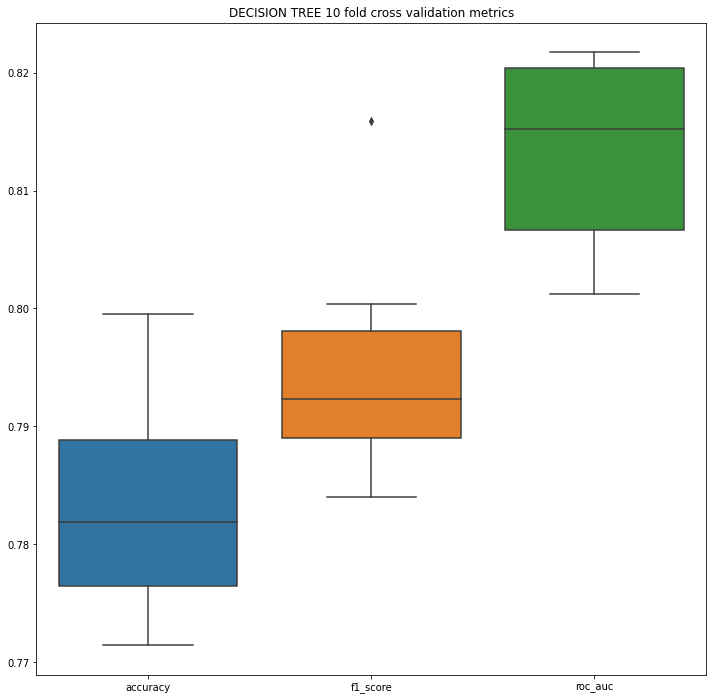

In [ ]:
plt.figure(figsize=(12,12))
sns.boxplot(data = scoring)
plt.title('DECISION TREE 10 fold cross validation metrics')
plt.show()

## Random Forest

In [21]:
kf = KFold(shuffle=True,n_splits=10,random_state=10)
kf_rf_acc = cross_val_score(rf_tfidf_ht, x_tfidf, y_tfidf, cv=kf, scoring='accuracy')
print(np.mean(kf_rf_acc))

0.799


In [22]:
kf_rf_acc

array([0.78285714, 0.80571429, 0.79619048, 0.79666667, 0.79761905,
       0.80857143, 0.79952381, 0.81380952, 0.80428571, 0.7847619 ])

In [23]:
kf = KFold(shuffle=True,n_splits=10,random_state=10)
kf_rf_f1 = cross_val_score(rf_tfidf_ht, x_tfidf, y_tfidf, cv=kf, scoring='f1')
print(np.mean(kf_rf_f1))

0.8053271901312689


In [24]:
kf_rf_f1

array([0.78368121, 0.81023256, 0.80294659, 0.79867987, 0.80333179,
       0.8135436 , 0.80837506, 0.82458502, 0.81773836, 0.79015785])

In [25]:
kf = KFold(shuffle=True,n_splits=10,random_state=10)
kf_rf_roc = cross_val_score(rf_tfidf_ht, x_tfidf, y_tfidf, cv=kf, scoring='roc_auc')
print(np.mean(kf_rf_roc))

0.857786064357174


In [26]:
kf_rf_roc

array([0.84453992, 0.86663171, 0.85369369, 0.8574557 , 0.86307588,
       0.85395519, 0.85548633, 0.87398765, 0.85788947, 0.8511451 ])

In [27]:
df_results_rf = pd.DataFrame([kf_rf_acc,kf_rf_f1,kf_rf_roc],
                                 index=['RF_Classifier_Accuracy', 
                                         'RF_Classifier_F1Score','RF_Classifer_AUCScore']) 

In [28]:
df_results_rf.T

,RF_Classifier_Accuracy,RF_Classifier_F1Score,RF_Classifer_AUCScore
0,0.782857,0.783681,0.844540
1,0.805714,0.810233,0.866632
2,0.796190,0.802947,0.853694
3,0.796667,0.798680,0.857456
4,0.797619,0.803332,0.863076
5,0.808571,0.813544,0.853955
6,0.799524,0.808375,0.855486
7,0.813810,0.824585,0.873988
8,0.804286,0.817738,0.857889
9,0.784762,0.790158,0.851145


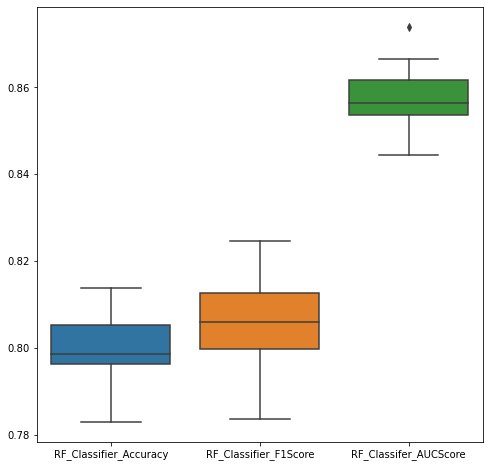

In [29]:
plt.figure(figsize=(8,8))
sns.boxplot(data=df_results_rf.T)
plt.show()

## Stacking Classifier

# K-Flod validation with stacking


In [16]:
kf= KFold(10, True, 1)
kf_stacking_acc= cross_val_score(stack,x_tfidf,y_tfidf,cv=kf,scoring='accuracy')

In [17]:
kf_stacking_acc

array([0.65619048, 0.64333333, 0.65619048, 0.64238095, 0.63428571,
       0.64904762, 0.65619048, 0.67428571, 0.65142857, 0.6552381 ])

In [18]:
kf= KFold(10, True, 1)
kf_stacking_f1= cross_val_score(stack,x_tfidf,y_tfidf,cv=kf,scoring='f1')

In [19]:
kf_stacking_f1

array([0.6515444 , 0.62939139, 0.64328063, 0.63596704, 0.63147793,
       0.65608959, 0.65053243, 0.66371681, 0.64671815, 0.64405113])

In [20]:
kf= KFold(10, True, 1)
kf_stacking_roc= cross_val_score(stack,x_tfidf,y_tfidf,cv=kf,scoring='roc_auc')

In [21]:
kf_stacking_roc

array([0.71080936, 0.70860552, 0.7149175 , 0.71343699, 0.70344968,
       0.71277294, 0.71292793, 0.73602231, 0.71513191, 0.71513889])

In [22]:
scores_df=pd.DataFrame([kf_stacking_acc,kf_stacking_f1,kf_stacking_roc])

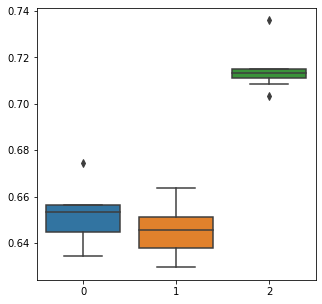

In [23]:
plt.figure(figsize=(5,5))
sns.boxplot(data=scores_df.T)
plt.show()

## Voting Classifier

In [33]:
kf = KFold(shuffle=True,n_splits=10,random_state=10)
kf_voting_acc = cross_val_score(model, x_tfidf, y_tfidf, cv=kf, scoring='accuracy')
print(np.mean(kf_voting_acc))

0.7906666666666667


In [34]:
kf_voting_acc

array([0.77904762, 0.79428571, 0.7847619 , 0.79285714, 0.78714286,
       0.78857143, 0.78238095, 0.81047619, 0.79095238, 0.79619048])

In [35]:
kf = KFold(shuffle=True,n_splits=10,random_state=10)
kf_voting_f1 = cross_val_score(model, x_tfidf, y_tfidf, cv=kf, scoring='f1')
print(np.mean(kf_voting_f1))

0.8005587950217585


In [36]:
kf_voting_f1

array([0.7854512 , 0.80255358, 0.79566004, 0.79852126, 0.79818594,
       0.79406308, 0.7947677 , 0.82513181, 0.80425155, 0.8070018 ])

In [37]:
kf = KFold(shuffle=True,n_splits=10,random_state=10)
kf_voting_roc = cross_val_score(model, x_tfidf, y_tfidf, cv=kf, scoring='roc_auc')
print(np.mean(kf_voting_roc))

0.8697157972151001


In [38]:
kf_voting_roc

array([0.86689892, 0.86758959, 0.86599164, 0.87812592, 0.87452554,
       0.86077152, 0.85934642, 0.88664729, 0.86367844, 0.87358268])

In [39]:
df_results_voting = pd.DataFrame([kf_voting_acc,kf_voting_f1,kf_voting_roc],
                                 index=['Voting_Classifier_Accuracy', 
                                         'Voting_Classifier_F1Score','Voting_Classifer_AUCScore']) 

In [40]:
df_results_voting.T

,Voting_Classifier_Accuracy,Voting_Classifier_F1Score,Voting_Classifer_AUCScore
0,0.779048,0.785451,0.866899
1,0.794286,0.802554,0.867590
2,0.784762,0.795660,0.865992
3,0.792857,0.798521,0.878126
4,0.787143,0.798186,0.874526
5,0.788571,0.794063,0.860772
6,0.782381,0.794768,0.859346
7,0.810476,0.825132,0.886647
8,0.790952,0.804252,0.863678
9,0.796190,0.807002,0.873583


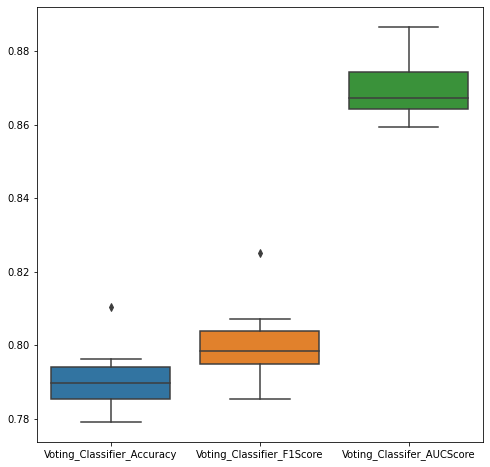

In [41]:
plt.figure(figsize=(8,8))
sns.boxplot(data=df_results_voting.T)
plt.show()

# Scores of all models for Comparision

In [11]:
pd.read_excel('Fake reviews data 1.xlsx ',index_col=[0,1,2])

Accuracy  \
            Model                      Vectoriz...                                     
Logistic Regression                                              Train      0.756429   
                                                            CV   Test       0.640476   
                                                           TFIDF Train      0.700000   
                                                                  Test      0.640000   
Decision Tree                                                    Train      0.537857   
                                                            CV   Test       0.531667   
                                                           TFIDF Train      0.565476   
                                                                  Test      0.560476   
Random Forest                                                    Train      0.612619   
                                                            CV   Test       0.643193   
                                                           TFIDF Train      0.644286   
                                                                  Test      0.670635   
Adaptive Boosting                                                Train      0.824037   
                                                            CV   Test       0.631667   
                                                           TFIDF Train      0.757605   
                                                                  Test      0.648095   
Stacking Classifier                                              Train      0.641607   
                                                            CV   Test       0.617619   
                                                           TFIDF Train      0.668036   
                                                                  Test      0.634524   

                                                                         F1-Score  \
            Model                      Vectoriz...                                  
Logistic Regression                                              Train   0.750000   
                                                            CV   Test    0.650000   
                                                           TFIDF Train   0.768006   
                                                                  Test   0.705987   
Decision Tree                                                    Train   0.660000   
                                                            CV   Test    0.650000   
                                                           TFIDF Train   0.670000   
                                                                  Test   0.660000   
Random Forest                                                    Train   0.585900   
                                                            CV   Test    0.624530   
                                                           TFIDF Train   0.644793   
                                                                  Test   0.676565   
Adaptive Boosting                                                Train   0.823015   
                                                            CV   Test    0.616984   
                                                           TFIDF Train   0.644198   
                                                                  Test   0.644198   
Stacking Classifier                                              Train   0.640000   
                                                            CV   Test    0.620000   
                                                           TFIDF Train   0.670000   
                                                                  Test   0.630000   

                                                                         ROC-AOC-Score  
            Model                      Vectoriz...                                      
Logistic Regression                                              Train        0.844150  
 

In [12]:
pd.read_excel('Grid Search CV Score Fake Reviews.xlsx',index_col=[0,1,2])

Accuracy  \
            Model                      Vectoriz...                                     
Logistic Regression                                              Train      0.756429   
                                                            CV   Test       0.640476   
                                                           TFIDF Train      0.700000   
                                                                  Test      0.640000   
Decision Tree                                                    Train      0.537857   
                                                            CV   Test       0.531667   
                                                           TFIDF Train      0.565476   
                                                                  Test      0.560476   
Random Forest                                                    Train      0.612619   
                                                            CV   Test       0.643193   
                                                           TFIDF Train      0.644286   
                                                                  Test      0.670635   
Logistic Regression                                              Train      0.756429   
                                                            CV   Test       0.640476   
                                                           TFIDF Train      0.700000   
                                                                  Test      0.640000   
Decision Tree                                                    Train      0.537857   
                                                            CV   Test       0.531667   
                                                           TFIDF Train      0.565476   
                                                                  Test      0.560476   
Random Forest                                                    Train      0.612619   
                                                            CV   Test       0.643193   
                                                           TFIDF Train      0.644286   
                                                                  Test      0.670635   

                                                                         F1-Score  \
            Model                      Vectoriz...                                  
Logistic Regression                                              Train   0.750000   
                                                            CV   Test    0.650000   
                                                           TFIDF Train   0.768006   
                                                                  Test   0.705987   
Decision Tree                                                    Train   0.660000   
                                                            CV   Test    0.650000   
                                                           TFIDF Train   0.670000   
                                                                  Test   0.660000   
Random Forest                                                    Train   0.585900   
                                                            CV   Test    0.624530   
                                                           TFIDF Train   0.644793   
                                                                  Test   0.676565   
Logistic Regression                                              Train   0.750000   
                                                            CV   Test    0.650000   
                                                           TFIDF Train   0.768006   
                                                                  Test   0.705987   
Decision Tree                                                    Train   0.660000   
                                                            CV   Test    0.650000   
                                                           TFIDF Train   0.670000   
  

In [14]:
pd.read_excel('Picking the Best paramater.xlsx',index_col=[0,1,2])

Accuracy  \
            Model                      Vectoriz...                                     
Logistic Regression                                              Train      0.756429   
                                                            CV   Test       0.640476   
                                                           TFIDF Train      0.700000   
                                                                  Test      0.640000   
Decision Tree                                                    Train      0.537857   
                                                            CV   Test       0.531667   
                                                           TFIDF Train      0.565476   
                                                                  Test      0.560476   
Random Forest                                                    Train      0.612619   
                                                            CV   Test       0.643193   
                                                           TFIDF Train      0.644286   
                                                                  Test      0.670635   

                                                                         F1-Score  \
            Model                      Vectoriz...                                  
Logistic Regression                                              Train   0.750000   
                                                            CV   Test    0.650000   
                                                           TFIDF Train   0.768006   
                                                                  Test   0.705987   
Decision Tree                                                    Train   0.660000   
                                                            CV   Test    0.650000   
                                                           TFIDF Train   0.670000   
                                                                  Test   0.660000   
Random Forest                                                    Train   0.585900   
                                                            CV   Test    0.624530   
                                                           TFIDF Train   0.644793   
                                                                  Test   0.676565   

                                                                         ROC-AOC-Score  
            Model                      Vectoriz...                                      
Logistic Regression                                              Train        0.844150  
                                                            CV   Test         0.706508  
                                                           TFIDF Train        0.700000  
                                                                  Test        0.650000  
Decision Tree                                                    Train        0.537233  
                                                            CV   Test         0.534230  
                                                           TFIDF Train        0.579896  
                                                                  Test        0.576465  
Random Forest                                                    Train        0.611756  
                                                            CV   Test         0.643395  
                                                           TFIDF Train        0.644467  
                                                                  Test        0.670574

In [15]:
pd.read_excel('Finalising the best model with all features.xlsx',index_col=[0,1,2])

Accuracy  \
            Model                 Vectorization...                                      
Logistic Regression                                               Train       0.82726   
                                                            TFIDF Test        0.79142   
Decision Tree                                              TFIDF  Train       1.00000   
                                                                   Test       0.73000   
Random Forest                                              TFIDF  Train       1.00000   
                                                                   Test       0.80000   
Adaptive Boosting with RF Tuned                            TFIDF  Train       0.90000   
                                                                   Test       0.80000   
Stacking Voting Classifier                                 TFIDF  Train       0.79000   
                                                                   Test       0.77000   

                                                                          F1-Score  \
            Model                 Vectorization...                                   
Logistic Regression                                               Train       0.83   
                                                            TFIDF Test        0.79   
Decision Tree                                              TFIDF  Train       1.00   
                                                                   Test       0.73   
Random Forest                                              TFIDF  Train       1.00   
                                                                   Test       0.80   
Adaptive Boosting with RF Tuned                            TFIDF  Train       0.91   
                                                                   Test       0.81   
Stacking Voting Classifier                                 TFIDF  Train       0.80   
                                                                   Test       0.78   

                                                                          ROC-AOC-Score  
            Model                 Vectorization...                                       
Logistic Regression                                               Train        0.914101  
                                                            TFIDF Test         0.860195  
Decision Tree                                              TFIDF  Train        1.000000  
                                                                   Test        0.720000  
Random Forest                                              TFIDF  Train        1.000000  
                                                                   Test        0.810000  
Adaptive Boosting with RF Tuned                            TFIDF  Train        0.970000  
                                                                   Test        0.870000  
Stacking Voting Classifier                                 TFIDF  Train        0.800000  
                                                                   Test        0.780000

In [16]:
pd.read_excel('Grid Search for Overfiting Model s.xlsx',index_col=[0,1,2])

Accuracy  \
            Model                 Vectorization...                                     
Adaptive Boosting                                          TFIDF Train      0.931548   
                                                                  Test      0.799524   
Decision Tree                                              TFIDF Train      0.785595   
                                                                  Test      0.772857   
Random Forest                                              TFIDF Train      0.810000   
                                                                  Test      0.780000   

                                                                         F1-Score  \
            Model                 Vectorization...                                  
Adaptive Boosting                                          TFIDF Train       0.93   
                                                                  Test       0.80   
Decision Tree                                              TFIDF Train       0.79   
                                                                  Test       0.77   
Random Forest                                              TFIDF Train       0.82   
                                                                  Test       0.79   

                                                                         ROC-AOC-Score  
            Model                 Vectorization...                                      
Adaptive Boosting                                          TFIDF Train        0.931530  
                                                                  Test        0.799605  
Decision Tree                                              TFIDF Train        0.815493  
                                                                  Test        0.804806  
Random Forest                                              TFIDF Train        0.820000  
                                                                  Test        0.790000